# -------------------- Imbalance Price Forecasting -----------------

## ------------ DEFINE ----------

## Background:
- **Electricity systems** need generation and supply to always be equal.
- To facilate this National Grid (ESO), requests each generator and supplier to inform **in advance** about their planned generation or demand, respectively.
- **Imbalance Volume** for each generator/supplier = (Planned - Actual) generation/demand.
- **Imbalance Price** in units of £/MWh --> The cost National Grid incurrs/take in **Correcting** the electricity system imbalance.
- Generators and Suppliers **pay or get paid** the Imbalance Price depending on the direction of their imbalance volume.

**BATTERY**
- Get PAID the Imbalance Price by **over-Discharging or under-charging** (i.e. discharging or charge more than the planned discharge or charge communicated to National Grid). 
- A Battery can PAY the Imbalance Price by **under-discharging or over-charging**. 
- This is sometimes a very attractive opportunity given the large range of imbalance prices. 
- **However, imbalance prices are not known in advance.**

## Objectives/Goals:

1. Exploring the data, identify the **main factors** that influence the imbalance price (for example, by correlating the imbalance price with other variables).
2. Develop a model that predicts the **imbalance price 15 minutes before** the settlement period starts. 


## Approach & Stratergies:
- **1. Load Required Datasets**
- **2. Data Discover or Data Understanding**
- **3. Data Pre-processing and Preparation**
    - **3.1 Data Merging**
    - **3.2 Scaling Data i.e. All Features with MWh unit**
    - **3.3 Handle Missing Values**

## -------- Part A: Identify Main Factors Influence Imbalance Price ----------------
- **1. Identify Correlated Features With Pearson Correlation and Visualization**
- **2. Verify the factors with Spearman Correlation**
- **3. Select and Document Main Factors Influence Imbalance Price**

## -------- Part B: Developed Model Predicts Imbalance Price 15 minute Before ----------------
- **1. Univariate forecasting**
- **2. Multivariate forecasting**


## ------------------ Key TakeAway Or Results -------------------------
### Part A:
- Top 5 Main Factors influence Imbalance Price  
    1. net_imbalance_volume
    2. Market_Price
    3. Ahead_Auction_Price
    4. Demand
    5. Hydropower

### Part B:
Univariate.png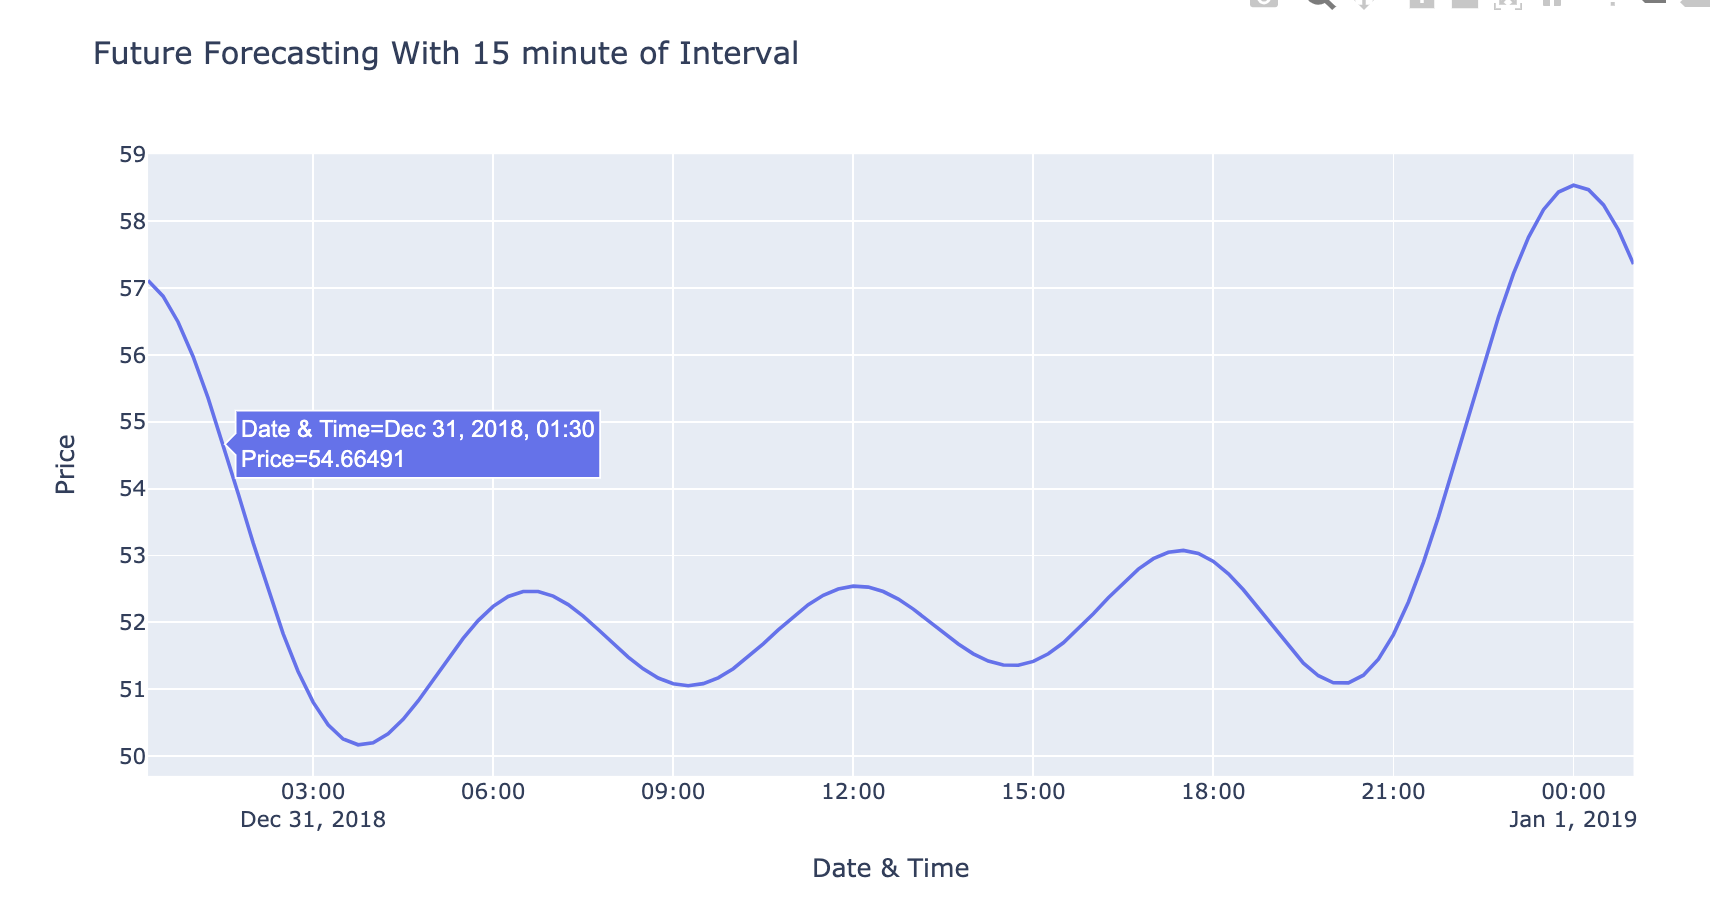

Multivariate.png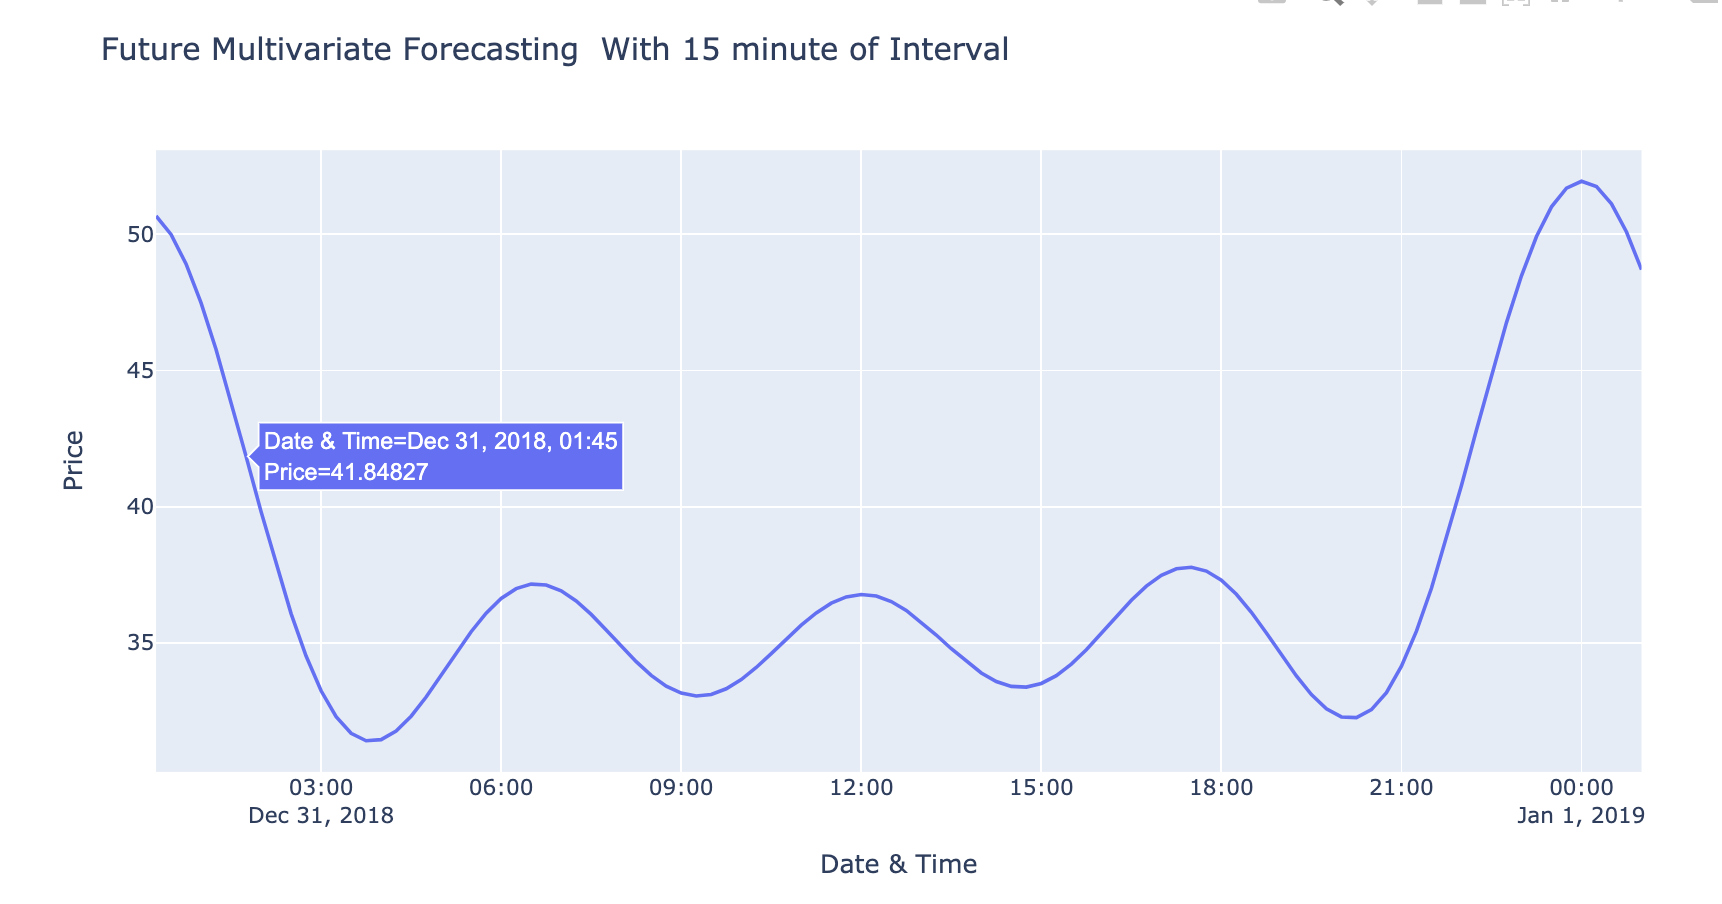

### Please Note:
- To reduce the notebook size of images and result.
- Comment some steps like .head() rows of dataframe, as those help during presentation.
- Also plotly images are not working in offline, Hence I attached screenshots in markdown.
- Thank you again for giving me this opportunity.

## ------------------------- Import libraries and Data ---------------------

In [1]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
import seaborn as sns
sns.set_style("whitegrid")
from math import sqrt
#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

#set to display more rows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Forcasting model libraries
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load data
Day_Ahead_Auction = pd.read_csv("./Dataset/day_ahead_auction.csv")
Demand = pd.read_csv("./Dataset/demand.csv")
Generation_Per_Type = pd.read_csv("./Dataset/generation_per_type.csv")
Imbalance = pd.read_csv("./Dataset/imbalance.csv")
Market_Index = pd.read_csv("./Dataset/market_index.csv")
Predicted_Generation = pd.read_csv("./Dataset/predicted_aggregated_generation.csv")
Predicted_Demand = pd.read_csv("./Dataset/predicted_demand.csv")
Predicted_Gas_Price = pd.read_csv("./Dataset/predicted_gas_price.csv")
Predicted_Wind_Solar_Generation = pd.read_csv("./Dataset/predicted_wind_and_solar_generation.csv")

## ------------------------- Data Discovery ----------------------------------------

In [3]:
# Function to retrive data characteristics

def Data_Discover(dataframe):
    print("---------------Size / Shape------------------")
    print(dataframe.shape)
    print("\n---------------Date Range------------------")
    print("From: ",dataframe.date.min())
    print("To: ",dataframe.date.max())
    print("\n---------------Descriptive statistics------------------")
    print(dataframe.describe())
    print("\n---------------Null values------------------")
    print(dataframe.isnull().sum())

In [4]:
Market_Index.head()

,date,period,price,volume
0,2016-01-01,1,30.86,403.50
1,2016-01-01,2,32.71,411.45
2,2016-01-01,3,35.56,585.70
3,2016-01-01,4,36.08,508.50
4,2016-01-01,5,36.22,516.50


In [5]:
#Data_Discover(Day_Ahead_Auction)
#Data_Discover(Demand)
#Data_Discover(Generation_Per_Type)
#Data_Discover(Imbalance)
#Data_Discover(Market_Index)
#Data_Discover(Predicted_Generation)
#Data_Discover(Predicted_Demand)
#Data_Discover(Predicted_Gas_Price)
#Data_Discover(Predicted_Wind_Solar_Generation)

## ------------------------- Observations & Data Understanding ------------------------
**All data file have**
- Date and a Period column
- PERIOD:
    - Settlement period in UK electiricity system
        - Each day divided in **48 i.e. half-hourly settlement periods**. (24 hours * 2 = 48)
        - 1st period (00:00 to 00:30)
        - 2nd period (00:30 to 1:00) etc..
- Some have Index column
    - Format: YYYYMMDDPP - PP (settlement period number)
    
### ---------------- Day_Ahead_Auction ----------------

- Data for day-ahead auction. Auction the **day before delivery** in which power is **sold and bought**. 
- Data available 24 hours day before period start.
- Shape: **(52608, 5)**
- **Null values: Volumne column**

**Features**
Size: Rows: 52608 Columns: 5
- **Date:** 
    - From:  2016-01-01
    - To:  2018-12-31
- Period:
- Price: 
    - Unit £/MWh - Price at which Total power Bought for each settlement.
    - ** 6 null values**
- Volumne: 
    - Unit MW - Total power bought in each settlement.
    - **246 null values**

### ---------------- Demand ----------------

- Actual Electricity Demand for each period of 30 mins.
- Data available just after the period ends
- Shape: **(52608, 4)**
- Zero Null values
**Features**
- Demand: Unit in MW for 30 min period.
- **Date:**
    - From:  2016-01-01
    - To:  2018-12-31
- Period:

### ---------------- Imbalance ----------------

- Actual imbalance price and net volumne of Electricity for each period of 30 mins.
- Just after the period ends.
- Shape: **(52608, 4)**
- **Zero Null values**
- Volume Unit: **MWh**

**Features**
- **date:**
    - From:  2016-01-01
    - To:  2018-12-31
- period
- imbalance_price: 
    - The cost National Grid incurrs/take in Correcting the electricity system imbalance.
    - Generators and Suppliers pay or get paid the Imbalance Price depending on the direction of their imbalance volume.

- net_imbalance_volume: 
    - Calculated by aggregating the imbalance of all Generators and Suppliers. 
    - Negative imbalance volumes represent **surplus/extra** of energy
        - generators are generating more than expected or 
        - suppliers are consuming less than expected. 
    - Positive imbalance volumes represent **deficit/less** of energy
        - generators are generating less than expected or 
        - suppliers are consuming more than expected.
    - **Unit: MWh**

### ---------------- Generation per type (Type of Electricity generators) ----------------

- Electricity generated by each types.
- Data Just after the period ends.
- Shape: **(52363, 14)**
- **Zero null values**
- All units : **MW for each 30 min period**

**Features**
- All type generated electricity - Unit in MW for 30 min period.
- biomass
- gas
- coal
- oil
- hydropower
- hydro_pumped_storage
- nuclear
- offshore_wind
- onshore_wind
- other
- solar
- **date** : 
    - From:  2016-01-01
    - To:  2018-12-31
- **period**


### ---------------- Maket Index ----------------

- Total power buyied in intraday market until 15 min before settlement period start.
- Data available just after the period ends
- Shape: **(52580, 4)**
- Null Values- **Price and volumne**
**Features**
- **Date:**
    - From:  2016-01-01
    - To:  2018-12-31
- Period:
- Price: £/MWh - **297 null values**
- Volumne: MW - **297 null values**

### ---------------- Aggregrated - Predicted Power Generation ----------------
- Data available 24 hours before the period starts.
- Shape: **(52512, 4)**
- **Null Values: Total Generation**

**Features**
- total_generation: MW - **48 null values**
- **date:**
    - From:  2016-01-01
    - To:  2018-12-31
- period

### ---------------- Predicted Power/Electricity Demand ----------------
- Data available 24 hours before the period starts.
- Shape - **(52608, 4)**
- **Zero null values**
**Features**
- Demand: MW for each 30 min of period.
- date:
    - From:  2016-01-01
    - To:  2018-12-31
- Preiod: 

### ---------------- Predicted Gas Price ----------------
- Data available 24 hours before the period starts.
- Shape - **(62454, 3)**
- Null values -**Gas Column**
**Features**
- date: 
    - From:  2016-01-01
    - To:  2019-07-24
- period:
- Gas_Price: £/MMBTU - **8 null values**

### ---------------- Predicted Wind & Solar Electricity Generation ----------------
- Data available 24 hours before the period starts.
- Shape: **(52560, 6)**
- **Zero null values**
**Features**
- date:
    - From:  2016-01-01
    - To:  2018-12-31
- period:
- solar: MW for each 30 min of period.
- offshore_wind: MW for each 30 min of period.
- onshore_wind: MW for each 30 min of period.


# --------------------------- Data Preparation -------------------------

In [6]:
def Data_Validation(dataframe):
    periods = dataframe['period']
    values = dataframe['period'].value_counts(ascending=False)
    
    print("\n ------Period-------")
    print(np.unique(periods))
    print("------Values-------")
    print("values",np.unique(values))
    print("------ >48 period -------")
    print(len(dataframe[periods > 48]))
    print("------ ==47 period -------")
    print(len(dataframe[periods == 47]))
    print("------ ==46 period -------")
    print(len(dataframe[periods == 46]))
    return

def Check_Null_Values(dataframe):
    print(dataframe.isnull().sum())
    sns.heatmap(dataframe.isnull(),yticklabels=False, cmap='viridis')
    return

def Visualise_Outliers(dataframe):
    fig = plt.figure(figsize=(10, 10))
    sns.boxplot(data=dataframe, orient="h", palette="Set2")

In [7]:
#print("\n --------- Day_Ahead_Auction -------------")
#Data_Validation(Day_Ahead_Auction)
#print("\n --------- Demand -------------")
#Data_Validation(Demand)
#print("\n --------- Generation_Per_Type -------------")
#Data_Validation(Generation_Per_Type)
#print("\n --------- Imbalance -------------")
#Data_Validation(Imbalance)
#print("\n --------- Market_Index -------------")
#Data_Validation(Market_Index)
#print("\n --------- Predicted_Generation -------------")
#Data_Validation(Predicted_Generation)
#print("\n --------- Predicted_Demand -------------")
#Data_Validation(Predicted_Demand)
#print("\n --------- Predicted_Gas_Price -------------")
#Data_Validation(Predicted_Gas_Price)
#print("\n --------- Predicted_Wind_Solar_Generation -------------")
#Data_Validation(Predicted_Wind_Solar_Generation)

## ------------------- Merging Data into Single Data Frame ---------------

### ------- Mergining Imbalance and Demand  -------

In [8]:

Demand_Imbalance = pd.merge(Demand, Imbalance)
Demand_Imbalance = Demand_Imbalance [['index','date','period','imbalance_price','net_imbalance_volume','demand']]
print(Demand_Imbalance.shape)
Demand_Imbalance.head()

(52608, 6)


,index,date,period,imbalance_price,net_imbalance_volume,demand
0,2016010101,2016-01-01,1,29.60000,-253.3504,28326
1,2016010102,2016-01-01,2,48.13640,55.8867,28934
2,2016010103,2016-01-01,3,49.02361,239.7857,28971
3,2016010104,2016-01-01,4,46.00000,18.1805,28213
4,2016010105,2016-01-01,5,48.50000,89.0833,27231


### ------- Mergining Imbalance - Demand and Generation Types -------

In [9]:
Generation_Per_Type.shape

(52363, 14)

In [10]:
Generation_Per_Type.head()

,index,biomass,gas,coal,oil,hydropower,hydro_pumped_storage,nuclear,offshore_wind,onshore_wind,other,solar,date,period
0,2016010148,0.0,4181.0,2321.0,0.0,40.0,712.0,8116.0,3853.0,4438.0,2032.0,0.0,2016-01-01,48
1,2016010147,0.0,4669.0,2270.0,0.0,192.0,712.0,8168.0,3861.0,4432.0,2006.0,0.0,2016-01-01,47
2,2016010146,0.0,4830.0,2855.0,0.0,380.0,720.0,8240.0,3845.0,4453.0,2042.0,0.0,2016-01-01,46
3,2016010145,0.0,5897.0,2991.0,0.0,344.0,721.0,8231.0,3829.0,4603.0,2044.0,0.0,2016-01-01,45
4,2016010144,0.0,6863.0,3109.0,0.0,349.0,720.0,8227.0,3801.0,4553.0,2039.0,0.0,2016-01-01,44


In [11]:
#droping date and period to avoid redundant coulmn
Generation_Per_Type_WO_Date_Period = Generation_Per_Type.drop(['date','period'],axis=1)

#Performing left join Left (Demand_Imbalance) and Right (Generation_Per_Type_WO_Date_Period)
#Resultant dataframe will have all rows from left dataframe and common from right.
#From right almost all rows will come as size of right table is less.
#52608-52363 = 245 null values will be created in resultant dataframe

Demand_Imbalance_Generation = Demand_Imbalance.merge(Generation_Per_Type_WO_Date_Period, on = 'index', how='left')
print(Demand_Imbalance_Generation.shape)
Demand_Imbalance_Generation.head()

(52608, 17)


,index,date,period,imbalance_price,net_imbalance_volume,demand,biomass,gas,coal,oil,hydropower,hydro_pumped_storage,nuclear,offshore_wind,onshore_wind,other,solar
0,2016010101,2016-01-01,1,29.60000,-253.3504,28326,0.0,5199.0,3514.0,0.0,0.0,851.0,8289.0,3252.0,3728.0,2036.0,0.0
1,2016010102,2016-01-01,2,48.13640,55.8867,28934,0.0,6530.0,3409.0,0.0,0.0,662.0,8292.0,2817.0,3627.0,2043.0,0.0
2,2016010103,2016-01-01,3,49.02361,239.7857,28971,0.0,6884.0,3861.0,0.0,0.0,646.0,8299.0,2501.0,3342.0,1940.0,0.0
3,2016010104,2016-01-01,4,46.00000,18.1805,28213,0.0,7028.0,3828.0,0.0,15.0,643.0,8286.0,2155.0,3244.0,1946.0,0.0
4,2016010105,2016-01-01,5,48.50000,89.0833,27231,0.0,6831.0,3634.0,0.0,0.0,642.0,8282.0,1605.0,2974.0,2047.0,0.0


### ------- Mergining Imbalance - Demand - Generation_Types and Market_Index -------

In [12]:
Market_Index.head()

,date,period,price,volume
0,2016-01-01,1,30.86,403.50
1,2016-01-01,2,32.71,411.45
2,2016-01-01,3,35.56,585.70
3,2016-01-01,4,36.08,508.50
4,2016-01-01,5,36.22,516.50


In [13]:
# before merginging makert index need to create new index column 
from datetime import datetime
Market_Index_Transform = Market_Index.copy()

# concate date and period to make index column
# replace - in date with help of **str.replace('-', '', regex=False)**
# add extra zero for single digit number .str.rjust(2,'0')
Market_Index_Transform['index'] = (Market_Index_Transform['date'].astype(str)).str.replace('-', '', regex=False)+ (Market_Index_Transform['period'].astype(str)).str.rjust(2,'0')
#Market_Index_Transform.head(10)


In [14]:
# add market index data into dataframe
#droping date and period to avoid redundant coulmn
Market_Index_Transform['index'] = Market_Index_Transform['index'].astype(int)
Market_Index_Transform = Market_Index_Transform.drop(['date','period'],axis=1)
Market_Index_Transform.rename(columns = {'price': 'market_price', 'volume': 'market_volume'}, inplace=True)


#Performing left join Left (Demend_Imbalance_Generation) and Right (Market_Index_Transform)
Demand_Imbalance_Generation_Market = Demand_Imbalance_Generation.merge(Market_Index_Transform, on = 'index', how='left')
print(Demand_Imbalance_Generation_Market.shape)
#Demand_Imbalance_Generation_Market.head()


(52608, 19)


### ------- Mergining --> Imbalance - Demand - Generation_Types - Market_Index and Day_Ahead_Auction -------

In [15]:
Day_Ahead_Auction.isnull().sum()

index       0
period      0
date        0
price       6
volume    246
dtype: int64

In [16]:
# add market index data into dataframe
#droping date and period to avoid redundant coulmn
Day_Ahead_Auction_WO_DP = Day_Ahead_Auction.drop(['date','period'],axis=1)
Day_Ahead_Auction_WO_DP.rename(columns = {'price': 'ahead_auction_price', 'volume': 'ahead_auction_volume'}, inplace=True)


#Performing left join Left (Demand_Imbalance_Generation_Market) and Right (Day_Ahead_Auction_WO_DP)
Demand_Imbalance_Generation_Market_Ahead = Demand_Imbalance_Generation_Market.merge(Day_Ahead_Auction_WO_DP, on = 'index', how='left')
print(Demand_Imbalance_Generation_Market_Ahead.shape)
Demand_Imbalance_Generation_Market_Ahead.head()


(52608, 21)


,index,date,period,imbalance_price,net_imbalance_volume,demand,biomass,gas,coal,oil,hydropower,hydro_pumped_storage,nuclear,offshore_wind,onshore_wind,other,solar,market_price,market_volume,ahead_auction_price,ahead_auction_volume
0,2016010101,2016-01-01,1,29.60000,-253.3504,28326,0.0,5199.0,3514.0,0.0,0.0,851.0,8289.0,3252.0,3728.0,2036.0,0.0,30.86,403.50,31.10,6342.2
1,2016010102,2016-01-01,2,48.13640,55.8867,28934,0.0,6530.0,3409.0,0.0,0.0,662.0,8292.0,2817.0,3627.0,2043.0,0.0,32.71,411.45,31.10,6342.2
2,2016010103,2016-01-01,3,49.02361,239.7857,28971,0.0,6884.0,3861.0,0.0,0.0,646.0,8299.0,2501.0,3342.0,1940.0,0.0,35.56,585.70,37.58,6109.5
3,2016010104,2016-01-01,4,46.00000,18.1805,28213,0.0,7028.0,3828.0,0.0,15.0,643.0,8286.0,2155.0,3244.0,1946.0,0.0,36.08,508.50,37.58,6109.5
4,2016010105,2016-01-01,5,48.50000,89.0833,27231,0.0,6831.0,3634.0,0.0,0.0,642.0,8282.0,1605.0,2974.0,2047.0,0.0,36.22,516.50,36.53,5927.6


In [17]:
Merged_Data = Demand_Imbalance_Generation_Market_Ahead.copy()

In [18]:
# Export into excel for future references
#Merged_Data.to_csv(r'Merged_Data.csv')

## -------------- Scaling/Converting Power into Electricity ---------------------

### Theory for scaling
- As we have:
    - Imbalance volume in MWh (for half hourly period)
    - Demand volume in MW (for half hourly period)
    - Generation volume in MW (for half hourly period)
- As imbalance price also in £/MWh
- Hence we convert MW into MWh for demand and generation.
- FORMULA USED: **1MWh = 1MW * 1 HOUR**
- Here we have data for 30 min period.
    - So, to conver MW into MWh by multiply 0.5
    - **1MWh (for half hour period) = 1MW * 0.5**

In [19]:
## Convert Demand, market_volume, ahead_auction_volume and all generation types volumne into MWh
cols = ['demand','biomass','gas','coal','oil','hydropower','hydro_pumped_storage','nuclear','offshore_wind','onshore_wind','other','solar','market_volume','ahead_auction_volume']
Merged_Data_MWh = Merged_Data.copy()
Merged_Data_MWh[cols] = Merged_Data_MWh[cols].multiply(0.5, axis="index")
Merged_Data_MWh.head()


,index,date,period,imbalance_price,net_imbalance_volume,demand,biomass,gas,coal,oil,hydropower,hydro_pumped_storage,nuclear,offshore_wind,onshore_wind,other,solar,market_price,market_volume,ahead_auction_price,ahead_auction_volume
0,2016010101,2016-01-01,1,29.60000,-253.3504,14163.0,0.0,2599.5,1757.0,0.0,0.0,425.5,4144.5,1626.0,1864.0,1018.0,0.0,30.86,201.750,31.10,3171.10
1,2016010102,2016-01-01,2,48.13640,55.8867,14467.0,0.0,3265.0,1704.5,0.0,0.0,331.0,4146.0,1408.5,1813.5,1021.5,0.0,32.71,205.725,31.10,3171.10
2,2016010103,2016-01-01,3,49.02361,239.7857,14485.5,0.0,3442.0,1930.5,0.0,0.0,323.0,4149.5,1250.5,1671.0,970.0,0.0,35.56,292.850,37.58,3054.75
3,2016010104,2016-01-01,4,46.00000,18.1805,14106.5,0.0,3514.0,1914.0,0.0,7.5,321.5,4143.0,1077.5,1622.0,973.0,0.0,36.08,254.250,37.58,3054.75
4,2016010105,2016-01-01,5,48.50000,89.0833,13615.5,0.0,3415.5,1817.0,0.0,0.0,321.0,4141.0,802.5,1487.0,1023.5,0.0,36.22,258.250,36.53,2963.80


## ----------------------- Handling Missing Values -----------------------------

In [20]:
Handle_Missing_Data = Merged_Data_MWh.copy()

index                     0
date                      0
period                    0
imbalance_price           0
net_imbalance_volume      0
demand                    0
biomass                 245
gas                     245
coal                    245
oil                     245
hydropower              245
hydro_pumped_storage    245
nuclear                 245
offshore_wind           245
onshore_wind            245
other                   245
solar                   245
market_price            325
market_volume           325
ahead_auction_price      12
ahead_auction_volume    252
dtype: int64


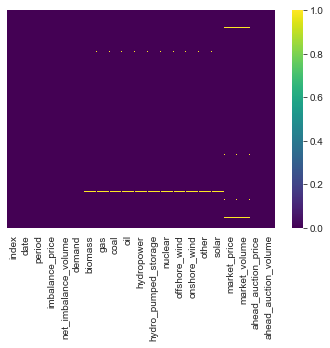

In [21]:
Check_Null_Values(Handle_Missing_Data)

### Observation:
- After merging all data
- Null values i.e data not available for periods:
    - Type of Generation
        - All columns - 245
    - Market_Index
        - Price and volume - 325
    - Day_ahead_Auction data
        - Price - 12 and Volume: 252
        
- As data is time series so need to analyse the data and then we able to replace the null values.


### ------- Handle null values for Type of Generation -----------

### Analysis on missing data

In [22]:
Merged_Data_MWh.columns

Index(['index', 'date', 'period', 'imbalance_price', 'net_imbalance_volume', 'demand', 'biomass', 'gas', 'coal', 'oil', 'hydropower', 'hydro_pumped_storage', 'nuclear', 'offshore_wind', 'onshore_wind', 'other', 'solar', 'market_price', 'market_volume', 'ahead_auction_price', 'ahead_auction_volume'], dtype='object')

In [23]:
TypeOfGenerationData = Merged_Data_MWh[['index','date','biomass', 'gas', 'coal', 'oil', 'hydropower',
       'hydro_pumped_storage', 'nuclear', 'offshore_wind', 'onshore_wind',
       'other', 'solar']]

#TypeOfGenerationData.head()

In [24]:
# lets check null values in TypeOfGeneration data
TypeOfGenerationNullData = TypeOfGenerationData[TypeOfGenerationData.isnull().any(axis=1)].sort_values(by=['date'])
#TypeOfGenerationNullData

In [25]:
#TypeOfGenerationNullData.date.value_counts()

### Observation:
- Found complete row for specific period is missing for all types of generation.
    - The missing data is for some periods in the whole day.
    - The maximum 5 periods miss for particular date and those 5 values are also not consecutive.
- So to handle this data we can impute last period observed data.
    - That is, forwarding last value to next null value
    - using function **ffill()**
    

In [26]:
# 1. select all type of generation columns 
columns = ['biomass', 'gas', 'coal', 'oil', 'hydropower',
       'hydro_pumped_storage', 'nuclear', 'offshore_wind', 'onshore_wind',
       'other', 'solar']

# 2. Replace all blanks in that column with NAN
Handle_Missing_Data[Handle_Missing_Data[columns]==""] = np.NaN

# 3. Replace all NaN values with last period observed data
Handle_Missing_Data[columns] = Handle_Missing_Data[columns].fillna(method='ffill')

# 4. Verify imputation
Handle_Missing_Data.isnull().sum()

index                     0
date                      0
period                    0
imbalance_price           0
net_imbalance_volume      0
demand                    0
biomass                   0
gas                       0
coal                      0
oil                       0
hydropower                0
hydro_pumped_storage      0
nuclear                   0
offshore_wind             0
onshore_wind              0
other                     0
solar                     0
market_price            325
market_volume           325
ahead_auction_price      12
ahead_auction_volume    252
dtype: int64

### ------- Handle null values for MARKET_INDEX data -----------

In [27]:
Market_Index_Data = Handle_Missing_Data[['index','date','market_price', 'market_volume']]
Market_Index_NULL_Data = Market_Index_Data[Market_Index_Data.isnull().any(axis=1)].sort_values(by=['date'])
#Market_Index_NULL_Data

In [28]:
#Market_Index_NULL_Data.date.value_counts()

## Observation
- For Market_Index missing data is not same as Type Of Generatation missing data.
- Found both column for specific period is missing.
    - The missing data is in sequence and not in sequence too.
    - The maximum 26 periods data is missing for particular date.
        - To handle such missing data i.e For specific date missing data is GREATER THAN 5
            - i will taking mean of all periods for that day and then impute.
        - For other rows where missing data is for some periods in particular date.
            - I will impute last observed data.

#### ------ Automate imputation ----- Missing values > 5 periods for a day -------

#### ---- To demonostrate below code working ------

In [29]:
#-----------Take all rows between index where market_price data is missing-----------

#filtered_df = Handle_Missing_Data.loc[Market_Index_Data['index'].between(2017051401, 2017051450)]
#filtered_df

#---------Now take indexes of missing data----------- 

#Null_Value_Index = filtered_df[filtered_df['market_price'].isnull()].index.tolist()
#Null_Value_Index
#len(Null_Value_Index)

# --------Calculate mean price and volume for that particular DAY----------

#mean_PRICE_day = filtered_df.market_price.mean()
#print("Mean_Price",mean_PRICE_day)
#mean_VOLUME_day = filtered_df.market_volume.mean()
#print("Mean_Volume",mean_VOLUME_day)

#-----------Imputation --------------
#------- 1. Iterate Null_Value_Index and imputer market_price and market_volume with mean price and volume of that day. 
#for indx in Null_Value_Index:
    #Handle_Missing_Data.loc[indx, 'market_price'] = mean_PRICE_day
    #Handle_Missing_Data.loc[indx, 'market_volume'] = mean_VOLUME_day
    
#----------2. Verfiy imputation ---------
#Handle_Missing_Data.isnull().sum()

In [30]:
MissingValueLowerIndex = [2017051401,2017051501,2016112301,2018103101,2016033101,2017110201,2018030101,
                     2017062501,2016122601,2016120901,2016033001,2018121201,2018022801,2017052101,
                     2018022701,2016061401]
MissingValueUpperIndex = [2017051450,2017051550,2016112350,2018103150,2016033150,2017110250,2018030150,
                     2017062550,2016122650,2016120950,2016033050,2018121250,2018022850,2017052150,
                     2018022750,2016061450]

for i,j in zip(MissingValueLowerIndex,MissingValueUpperIndex):
    
    #Take all rows between index where market_price data is missing
    filtered_df = Handle_Missing_Data.loc[Market_Index_Data['index'].between(i, j)]
    

    # Now take indexes of missing data 
    Null_Value_Index = filtered_df[filtered_df['market_price'].isnull()].index.tolist()

    
    # Calculate mean price and volume for that particular DAY
    mean_PRICE_day = filtered_df.market_price.mean()
    mean_VOLUME_day = filtered_df.market_volume.mean()
    
    
    #Iterate Null_Value_Index and imputer market_price and market_volume with mean price and volume of that day. 
    for indx in Null_Value_Index:
        Handle_Missing_Data.loc[indx, 'market_price'] = mean_PRICE_day
        Handle_Missing_Data.loc[indx, 'market_volume'] = mean_VOLUME_day
    
    #Validation
    print("Imputation complete for row: ",len(Null_Value_Index))



Imputation complete for row:  26
Imputation complete for row:  16
Imputation complete for row:  14
Imputation complete for row:  12
Imputation complete for row:  12
Imputation complete for row:  11
Imputation complete for row:  9
Imputation complete for row:  9
Imputation complete for row:  9
Imputation complete for row:  8
Imputation complete for row:  8
Imputation complete for row:  8
Imputation complete for row:  7
Imputation complete for row:  7
Imputation complete for row:  6
Imputation complete for row:  6


### Imputation ----- Missing values < 5 periods for a day -------

In [31]:
# 1. select all Market_price and volume columns 
columns = ['market_price','market_volume']

# 2. Replace all blanks in that column with NAN
Handle_Missing_Data[Handle_Missing_Data[columns]==""] = np.NaN

# 3. Replace all NaN values with last period observed data
Handle_Missing_Data[columns] = Handle_Missing_Data[columns].fillna(method='ffill')

# 4. Verify All Imputation
Handle_Missing_Data.isnull().sum()

index                     0
date                      0
period                    0
imbalance_price           0
net_imbalance_volume      0
demand                    0
biomass                   0
gas                       0
coal                      0
oil                       0
hydropower                0
hydro_pumped_storage      0
nuclear                   0
offshore_wind             0
onshore_wind              0
other                     0
solar                     0
market_price              0
market_volume             0
ahead_auction_price      12
ahead_auction_volume    252
dtype: int64

### ------- Handle null values for Day_Ahead data -----------

### ---- Analysis-----

In [32]:
Auction_Data = Handle_Missing_Data[['index','date','ahead_auction_price', 'ahead_auction_volume']]
Auction_NULL_Data = Auction_Data[Auction_Data.isnull().any(axis=1)].sort_values(by=['date'])
#Auction_NULL_Data

In [33]:
Auction_NULL_Data.date.value_counts()

2016-09-29    48
2016-09-30    48
2016-10-01    48
2016-10-05    48
2016-10-02    48
2016-10-30     2
2016-03-27     2
2018-10-28     2
2017-03-26     2
2017-10-29     2
2018-03-25     2
Name: date, dtype: int64

### Observation:
- 2016
    - September - 29, 30
    - October - 01, 02, 05, 30
    - Whole day data is missing.
    - I google but not able to get 2016 data.
    - To speed up process i am updating those day data with last observed day data.

## Observation
- The missing data in Auction seems due to DAY LIGHT SAVING time switch.
- Data verified by website: https://www.nordpoolgroup.com/Market-data1/GB/Auction-prices/UK/Hourly/?view=table
    - To handle missing data for those period
    - Imputing zero as that data already recorded.

In [34]:
#--- Day light saving data index ------
DateIndex = [2016103049,2016103050,2017032603,2017032604,2017102949,2017102950,2018032503,2018032504,2018102849,2018102850]
DayLightSavingIndex = [14590,14591,21602,21603,32062,32063,39074,39075,49534,49535]
#pd.DataFrame(Merged_Data_MWh, index=DayLightSavingIndex)

### Observation
- After looking at above data.
- Even there is time shift electricity consumed, generated.
- Here data for transaction is not there.
- To go further i am imputing last observed value to make data set ready for further analysis.
- **Note:** May my approach wrong for this data but like to discuss on the same.

#### ----- Imputing day light saving data with last observed data --------

In [35]:
# 1. select all Ahead_Auction price and volume columns 
columns = ['ahead_auction_price','ahead_auction_volume']

# 2. Replace all blanks in that column with NAN
Handle_Missing_Data[Handle_Missing_Data[columns]==""] = np.NaN

# 3. Replace all NaN values with last period observed data
Handle_Missing_Data[columns] = Handle_Missing_Data[columns].fillna(method='ffill')

# 4. Verify All Imputation
Handle_Missing_Data.isnull().sum()

index                   0
date                    0
period                  0
imbalance_price         0
net_imbalance_volume    0
demand                  0
biomass                 0
gas                     0
coal                    0
oil                     0
hydropower              0
hydro_pumped_storage    0
nuclear                 0
offshore_wind           0
onshore_wind            0
other                   0
solar                   0
market_price            0
market_volume           0
ahead_auction_price     0
ahead_auction_volume    0
dtype: int64

index                   0
date                    0
period                  0
imbalance_price         0
net_imbalance_volume    0
demand                  0
biomass                 0
gas                     0
coal                    0
oil                     0
hydropower              0
hydro_pumped_storage    0
nuclear                 0
offshore_wind           0
onshore_wind            0
other                   0
solar                   0
market_price            0
market_volume           0
ahead_auction_price     0
ahead_auction_volume    0
dtype: int64


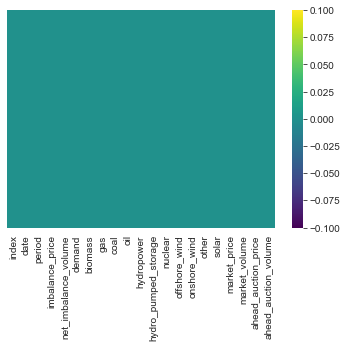

In [36]:
Check_Null_Values(Handle_Missing_Data)

In [37]:
# Check is there any duplicated value
Handle_Missing_Data.duplicated().sum()

0

In [38]:
# Export prepared into csv for future references
#Handle_Missing_Data.to_csv(r'Clean_Merged_Data.csv')

## Data Preparation - Summary.

1. Merged all required data
    - Day_Ahead_Auction
    - Demand
    - Generation_Per_Type
    - Imbalance
    - Market_Index
2. Scaling Data into same Unit i.e. MWh.

2. Handle all missing values with proper analysis.

3. We have now our clean and prepared data for further analysis.

# ----- Part A - Identify Main Factors That Influence Imbalance Price -----

In [39]:
PartAData = Handle_Missing_Data.copy()

### ------------------- Identify Correlated Features With Pearson Correlation and Visualization -----------------

In [40]:
CorrelationData = PartAData.drop(['index','date'], axis = 1)
Correlation = CorrelationData.corr(method = 'pearson')  ## Pearson Correlation Coefficient default method parameter of corr()

In [41]:
Correlation['imbalance_price'].sort_values(ascending = False)

imbalance_price         1.000000
market_price            0.520277
net_imbalance_volume    0.510599
ahead_auction_price     0.304594
hydropower              0.273507
demand                  0.245371
biomass                 0.211811
gas                     0.199426
coal                    0.171836
hydro_pumped_storage    0.155515
market_volume           0.099626
period                  0.091594
ahead_auction_volume    0.043637
oil                     0.019312
onshore_wind            0.018484
offshore_wind           0.002954
solar                  -0.072963
nuclear                -0.109302
other                  -0.171528
Name: imbalance_price, dtype: float64

<AxesSubplot:>

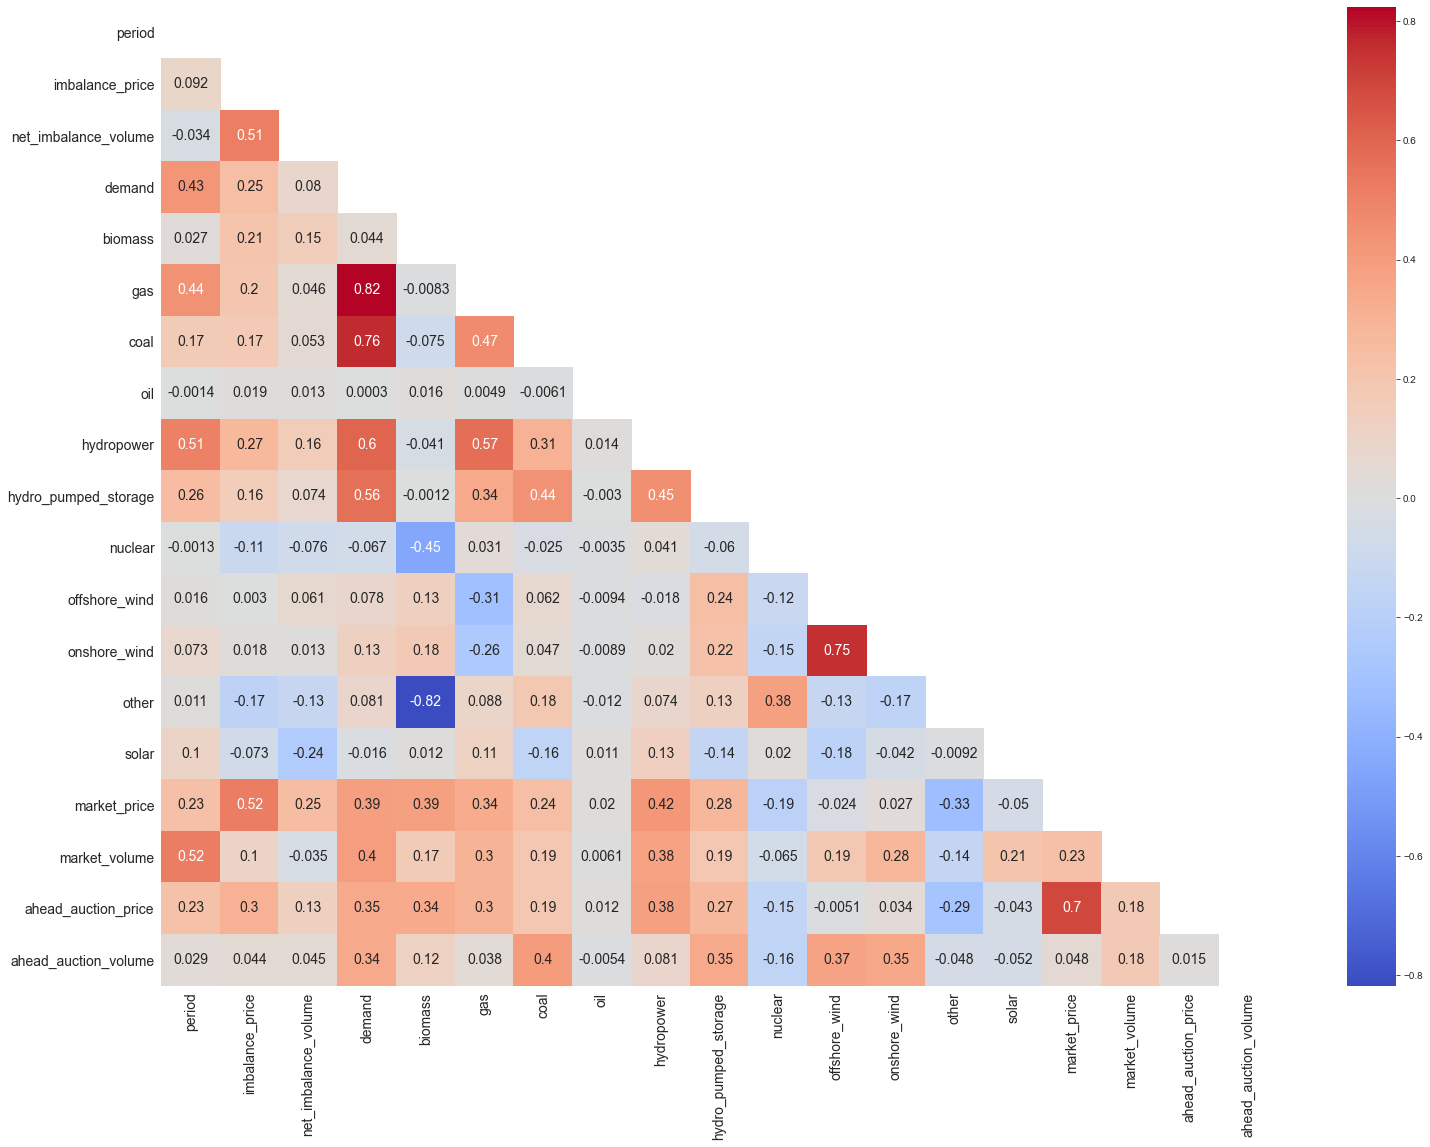

In [42]:
#--- Visualize correlation ----
# Create array with all zero same size of correlation
ZeroMaskArray = np.zeros_like(Correlation)
# take indicies of upper triangle of array
UpperTraingularIndices = np.triu_indices_from(ZeroMaskArray)
ZeroMaskArray[UpperTraingularIndices] = True
#Now visualize this array
plt.figure(figsize = (25,18))
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
sns.heatmap(Correlation, mask = ZeroMaskArray, annot=True, annot_kws = {"size":14}, cmap='coolwarm')



### Observations 
- More dark colour indicate high correlation.
- Imbalance_Price (Target Vairable)
    - Highly (positively) correlated vairables i.e. pearson correlation value close to 0.1 are
        - Market_Price
        - net_imbalance_volume
        - Ahead_Auction_Price
        - Hydropower
        - Demand
        - Biomass
        - Gas
        - Coal
        - Hydro_pumped_storage
        - Market_Volume

    - Inversely (negatively) correlated vairables are
        - Other
        - Nuclear
        - Solar
        
- As i checked negative correlation are those type of generation which are not frequently used.
- Inshort imblance_price have some sort of correlation with 
    - all frequently used electricity generation types
    - demand (**assumption:** May be during balancing demand/generation, imbalance_price gets triggered)
    - market price (**assumption:** May be to while balance demand/generation, market_price gets increase or decrease)


In [43]:
# As pairplot for all vairables at a time visualisation is not analysable.
# Correaltion between imbalance_price and volume with all generation types
#plt.rcParams['figure.figsize']=(20,10)
#Imbalance_GenerationTypes = CorrelationData[['imbalance_price', 'net_imbalance_volume', 'biomass', 'gas', 'coal', 
                                             #'oil', 'hydropower', 'hydro_pumped_storage', 'nuclear', 'offshore_wind',
                                             #'onshore_wind', 'other', 'solar']]
Positive_Corr_Independent_Features = ['index','market_price', 'net_imbalance_volume', 'ahead_auction_price','hydropower', 
                                       'demand', 'biomass', 'gas', 'coal', 'hydro_pumped_storage', 'market_volume']
Negative_Corr_Independent_Features = ['index', 'solar', 'nuclear', 'other']

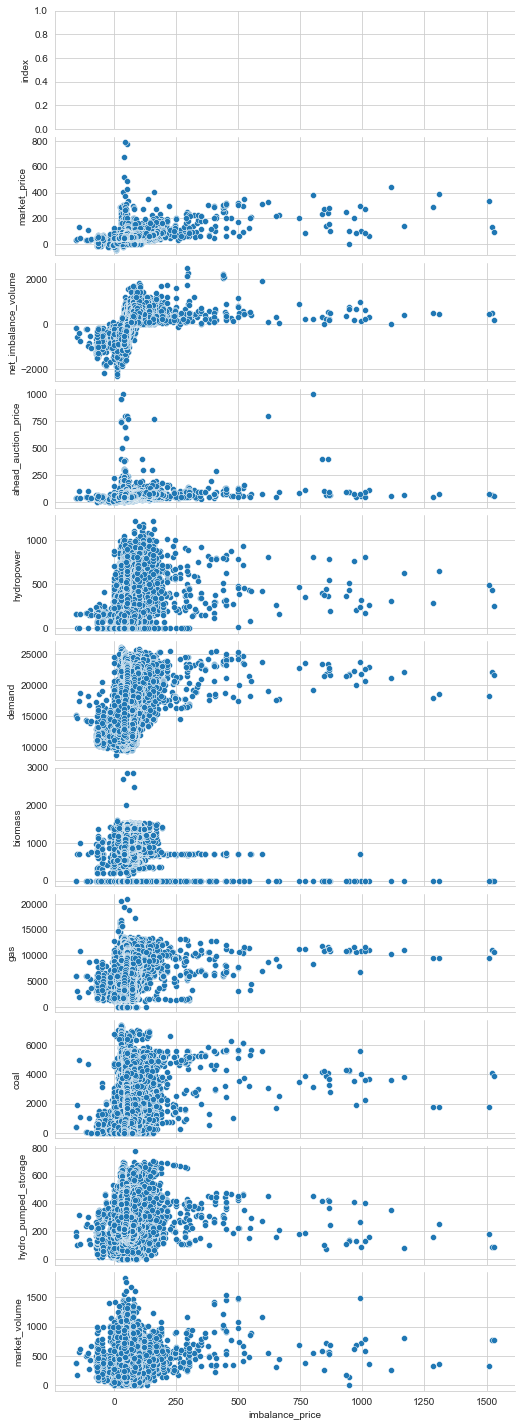

In [44]:
PairPlot = sns.pairplot(data=PartAData,x_vars=['imbalance_price'],y_vars = Positive_Corr_Independent_Features)
#PairPlot = sns.pairplot(data=PartAData,x_vars=['imbalance_price'],y_vars = Positive_Corr_Independent_Features, kind = 'reg')
PairPlot.fig.set_size_inches(10,20)




## Observation:
- Most of variables concentrated between 0 to 300 £/MWh and then scattered.
- Also have positive correlation.
- With initial observation we can see there are outliers present in data.

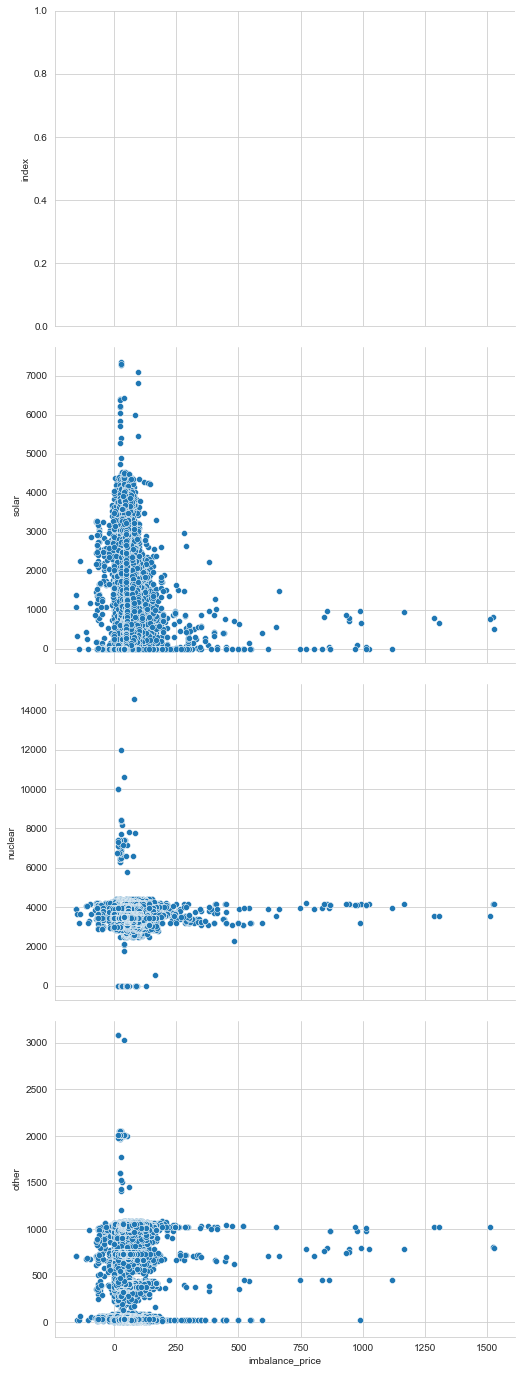

In [45]:
PairPlot = sns.pairplot(data=PartAData,
                  x_vars=['imbalance_price'],
                  y_vars = Negative_Corr_Independent_Features)
PairPlot.fig.set_size_inches(10,20)

### Observation:
- Most of variables concentrated between 0 to 300 £/MWh and then scattered.
- With initial observation we can see there are outliers present in data.

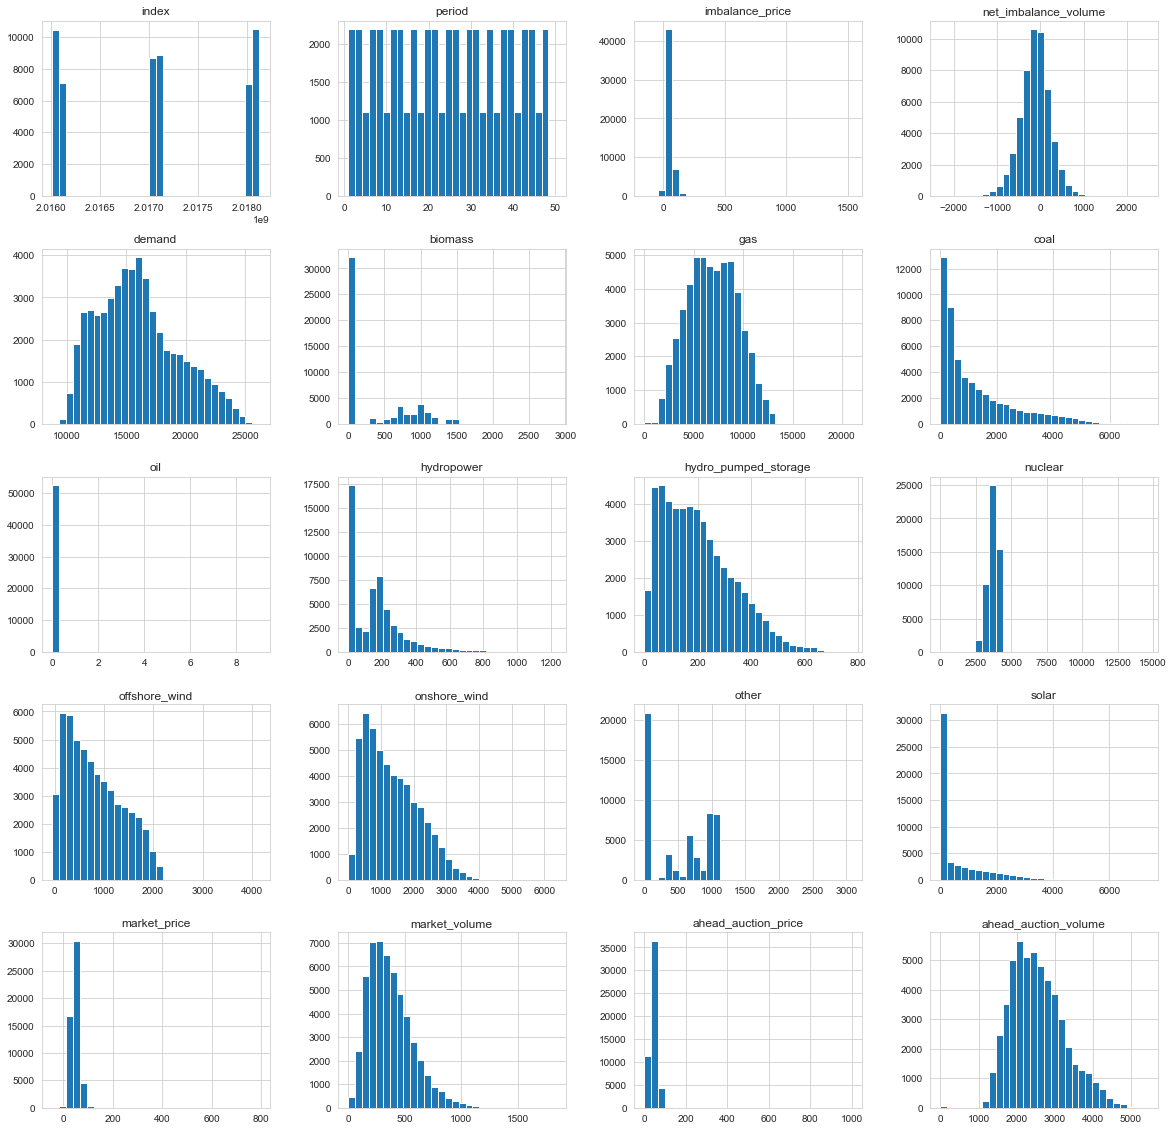

In [46]:
plots = PartAData.hist(bins=30, figsize=(20, 20))

### Observation:
- By analysing pairplot and histogram data distribution:
    - Data is not showing correct linear relationship.
    - Few variables have linear relationship with imbalance_price few not.
- To verify highly correlated factors in such condition.
    - Try spearman correlation and compare the with pearson correlation variables.


## ------------------- Implementing Spearman Correlation ----------
- Variables may be related by a nonlinear relationship, such that the relationship is stronger or weaker across the distribution of the variables.
- Further, the variables being considered may have a non-Gaussian distribution.

In [47]:
SpearmanCorrelation = CorrelationData.corr(method = 'spearman')

In [48]:
SpearmanCorrelation['imbalance_price'].sort_values(ascending = False)

imbalance_price         1.000000
net_imbalance_volume    0.724977
market_price            0.631831
ahead_auction_price     0.544873
biomass                 0.452693
demand                  0.254198
gas                     0.205635
hydropower              0.198360
hydro_pumped_storage    0.173045
ahead_auction_volume    0.129091
market_volume           0.116874
coal                    0.112115
period                  0.099934
onshore_wind            0.058557
offshore_wind           0.048378
oil                     0.016421
solar                  -0.035114
nuclear                -0.217544
other                  -0.349103
Name: imbalance_price, dtype: float64

### Observations 
- Spearman Correlation given vairables
- Imbalance_Price (Target Vairable)
    - Highly (positively) correlated vairables i.e. spearman correlation value close to 0.1 are
        - net_imbalance_volume
        - Market_Price
        - Ahead_Auction_Price
        - Demand
        - Biomass
        - Gas
        - Hydropower
        - ahead_auction_volume
        - Hydro_pumped_storage
        - Market_Volume
        - Coal

    - Inversely (negatively) correlated vairables are
        - Other
        - Nuclear
        - Solar
        

# ---------------------- Conclusion Part A ---------------------------------------
- After analysing both Pearson and Spearman Correlation
- Out of 18 features (except Index, Date & Period) main factors (Top 5) influence imbalance price are:
    1. net_imbalance_volume
    2. Market_Price
    3. Ahead_Auction_Price
    4. Demand
    5. Hydropower

# ------------------------------------ Part B --------------------------------------------

### ----- Develop a model that predicts the imbalance price 15 minutes before the settlement period starts. -----

In [49]:
# Take clean dataset
PartBData = Handle_Missing_Data.copy()
PartBData['date'] =  pd.to_datetime(PartBData['date'], format='%Y-%m-%d')

In [50]:
PartBData.head()

,index,date,period,imbalance_price,net_imbalance_volume,demand,biomass,gas,coal,oil,hydropower,hydro_pumped_storage,nuclear,offshore_wind,onshore_wind,other,solar,market_price,market_volume,ahead_auction_price,ahead_auction_volume
0,2016010101,2016-01-01,1,29.60000,-253.3504,14163.0,0.0,2599.5,1757.0,0.0,0.0,425.5,4144.5,1626.0,1864.0,1018.0,0.0,30.86,201.750,31.10,3171.10
1,2016010102,2016-01-01,2,48.13640,55.8867,14467.0,0.0,3265.0,1704.5,0.0,0.0,331.0,4146.0,1408.5,1813.5,1021.5,0.0,32.71,205.725,31.10,3171.10
2,2016010103,2016-01-01,3,49.02361,239.7857,14485.5,0.0,3442.0,1930.5,0.0,0.0,323.0,4149.5,1250.5,1671.0,970.0,0.0,35.56,292.850,37.58,3054.75
3,2016010104,2016-01-01,4,46.00000,18.1805,14106.5,0.0,3514.0,1914.0,0.0,7.5,321.5,4143.0,1077.5,1622.0,973.0,0.0,36.08,254.250,37.58,3054.75
4,2016010105,2016-01-01,5,48.50000,89.0833,13615.5,0.0,3415.5,1817.0,0.0,0.0,321.0,4141.0,802.5,1487.0,1023.5,0.0,36.22,258.250,36.53,2963.80


### ------- Lets first forecast on the basis of Imbalance_Price i.e Univariant Forecasting-----

In [51]:
# Some helper functions
def VisualizeTrend(dataframe, label):
    plt.gcf().set_size_inches(10, 10)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dataframe.index, y=dataframe, mode='lines', name='demand'))
    fig.update_layout(showlegend=True, title = label, xaxis_title="Date/Time", yaxis_title="Demand",)
    fig.show()
    return None

In [52]:
AnalysisDataFrame = PartBData[['date','period','imbalance_price']]
AnalysisDataFrame.head()

,date,period,imbalance_price
0,2016-01-01,1,29.60000
1,2016-01-01,2,48.13640
2,2016-01-01,3,49.02361
3,2016-01-01,4,46.00000
4,2016-01-01,5,48.50000


In [53]:
AnalysisDataFrame.dtypes

date               datetime64[ns]
period                      int64
imbalance_price           float64
dtype: object

In [54]:
AnalysisDataFrame.set_index('date', inplace=True)
AnalysisDataFrame.head()


,period,imbalance_price
date,,
2016-01-01,1,29.60000
2016-01-01,2,48.13640
2016-01-01,3,49.02361
2016-01-01,4,46.00000
2016-01-01,5,48.50000


In [56]:
label = "Half Hourly Imbalance Price Trend"
VisualizeTrend(AnalysisDataFrame.imbalance_price, label)

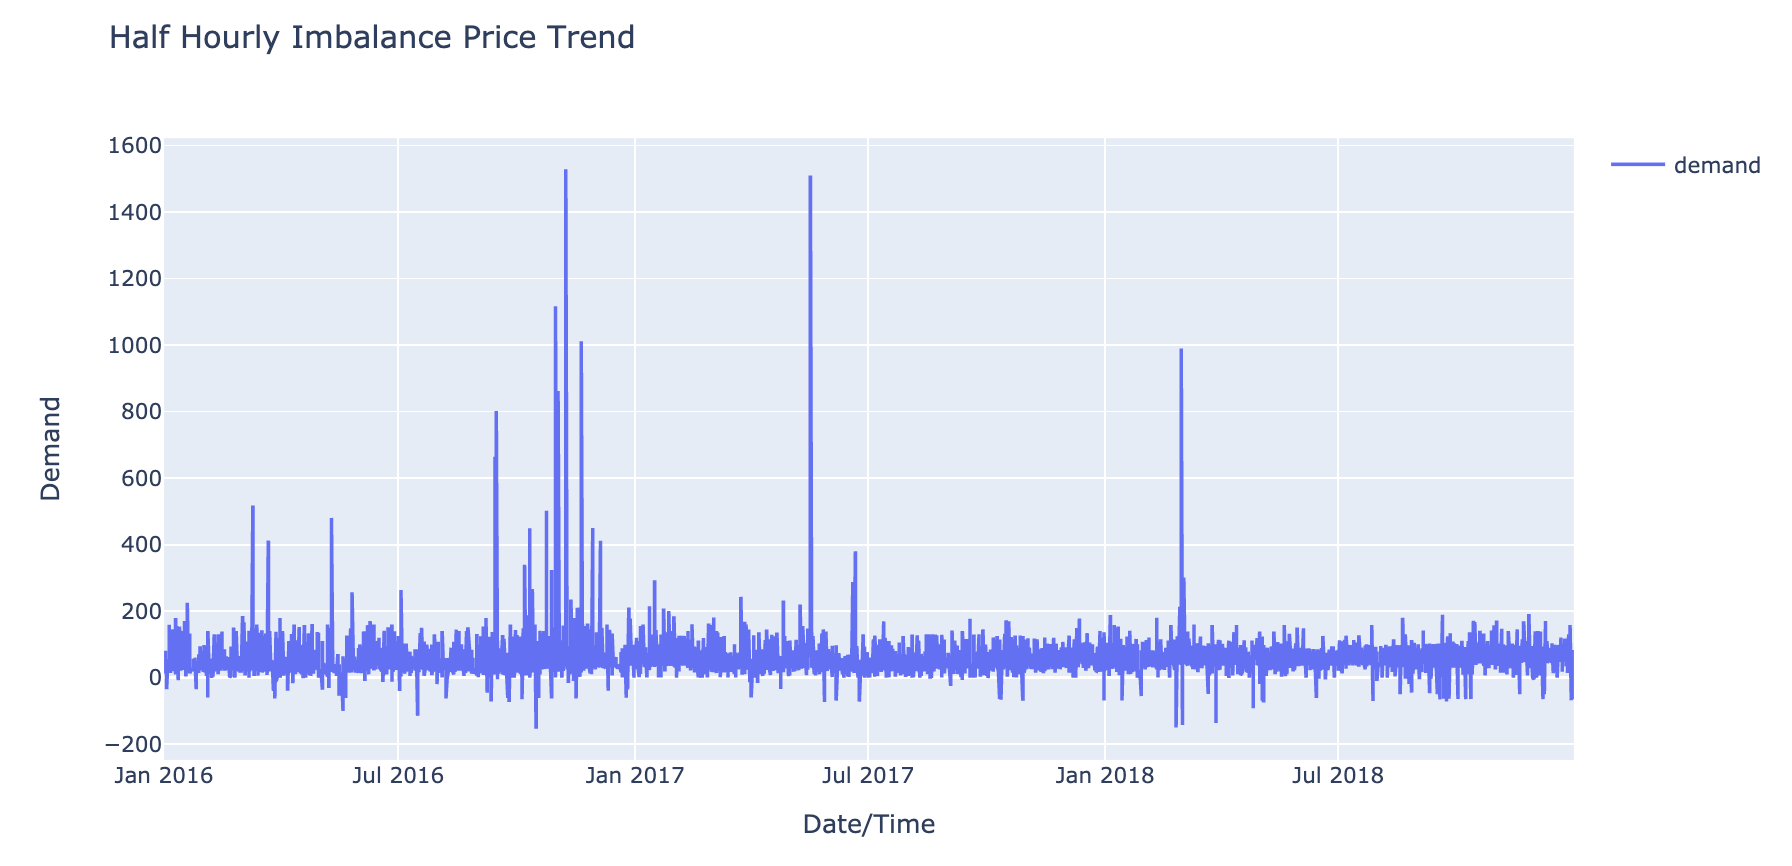

## Observation:
- There are lot more spikes i.e outliers in dataset.

## ----- Outlier Visualization ----------

In [57]:

def VisualiseDistribution(dataframe):
    sns.set(style="ticks")
    # Cut the window in 2 parts
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Add a graph in each part
    sns.boxplot(dataframe, ax=ax_box, palette="Blues")
    sns.distplot(dataframe, ax=ax_hist, rug = True, color="teal")

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='demand')


def Outlier_Range(dataframe):
    DescriptiveStats = dataframe.describe()

    IQR = DescriptiveStats['75%'] - DescriptiveStats['25%']
    
    upper = DescriptiveStats['75%'] + 1.5 * IQR

    lower = DescriptiveStats['25%'] - 1.5 * IQR
    print('The upper bounds for suspected outliers are {} '.format(upper))
    print('The lower bounds for suspected outliers are {}'.format(lower))

The upper bounds for suspected outliers are 101.6266625 
The lower bounds for suspected outliers are -15.375997499999997


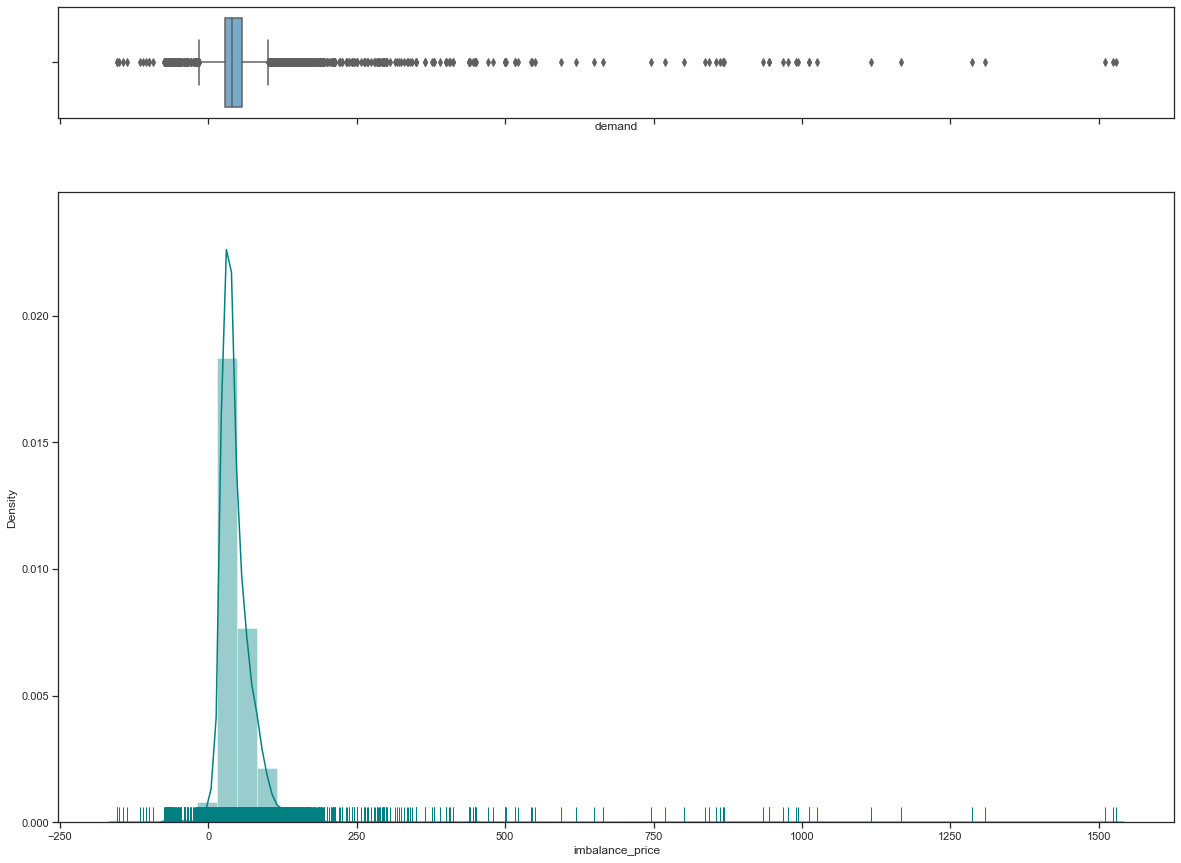

In [58]:
rcParams['figure.figsize'] = 20,15
Outlier_Range(AnalysisDataFrame.imbalance_price)
VisualiseDistribution(AnalysisDataFrame.imbalance_price)

### Observation:
- As here lots of outliers.
- Intially my approach was to handle these outlier but as i had previously worked with Facebook prophet timeseries forecasting.
    - The Facebook prophet time series forecasting model have capacity to handle outliers.
- Hence, I first try the model and if results ask for outlier handling then we can do the same.

### Lets visualize how outliers are spread in dataset.
- It help to get insight on spread of outliers.

In [59]:
#Helper function help to create new feature using date column.

def create_features(dataframe, label=None):
    df = dataframe.copy()
    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    
    X = df[['quarter','month','year',
           'dayofyear']]
    if label:
        y = df[label]
        return X, y
    return X



In [60]:
X, y = create_features(AnalysisDataFrame, label='imbalance_price')
X['period'] = AnalysisDataFrame['period']
ConcatedDataFrame = pd.concat([X, y], axis=1)
ConcatedDataFrame.head()

,quarter,month,year,dayofyear,period,imbalance_price
date,,,,,,
2016-01-01,1,1,2016,1,1,29.60000
2016-01-01,1,1,2016,1,2,48.13640
2016-01-01,1,1,2016,1,3,49.02361
2016-01-01,1,1,2016,1,4,46.00000
2016-01-01,1,1,2016,1,5,48.50000


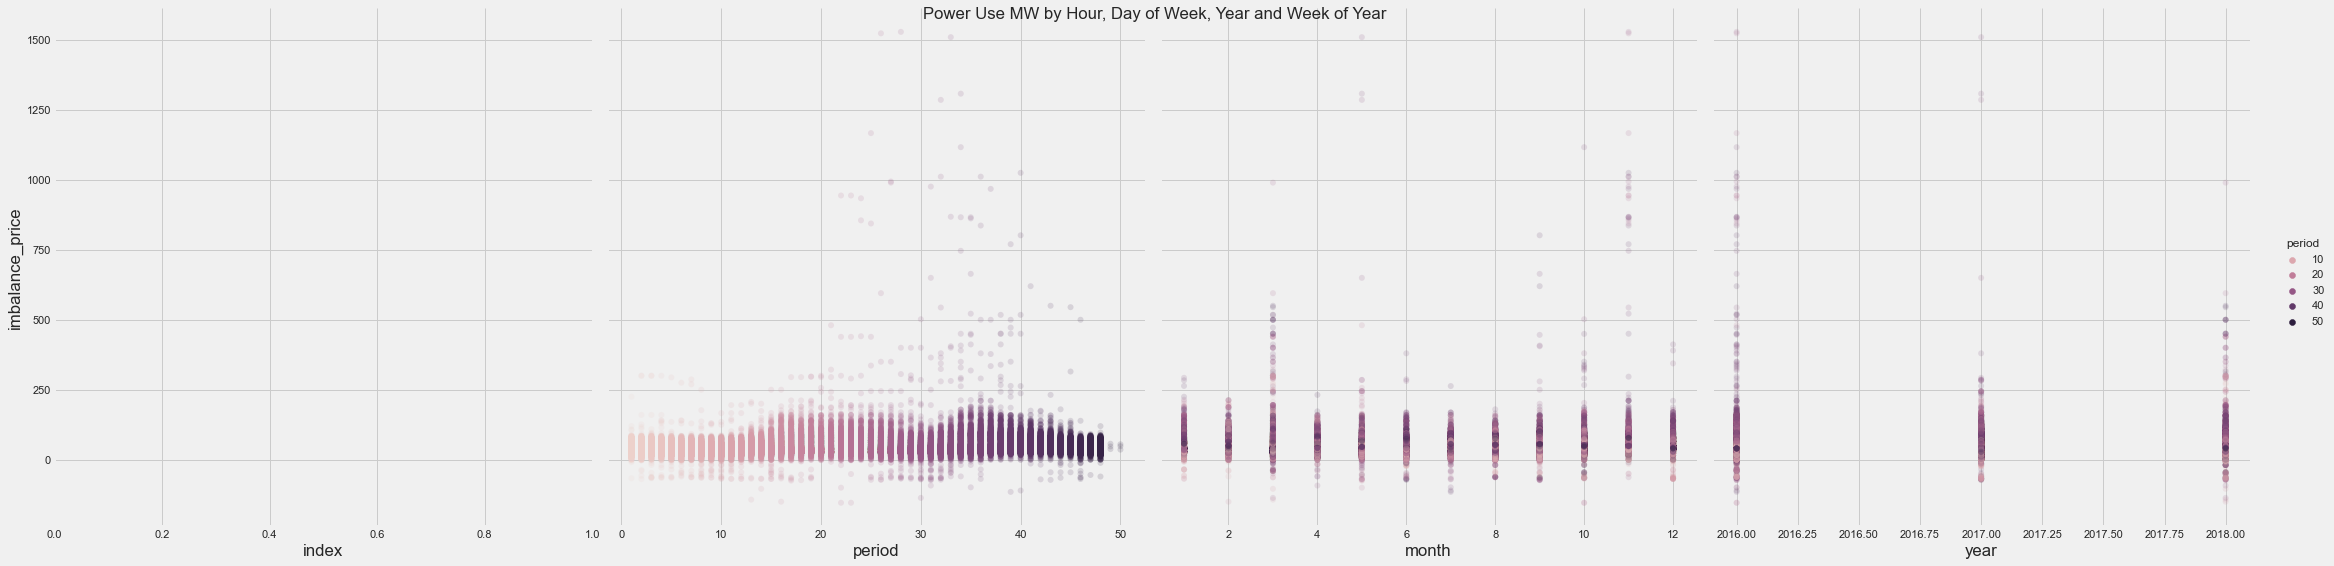

In [61]:
plt.style.use('fivethirtyeight') # For plots
sns.pairplot(ConcatedDataFrame,
             hue='period',
             x_vars=['index','period','month',
                     'year'],
             y_vars='imbalance_price',
             height=8,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

### Observation:
- Maxmimum outliers spread within period.
    - But concentration of data is within range of 0 to 250 which is good sign.
    - As Profhet model will able handle this outliers.
- When we group data monthly then maximum outliers observed from september.
    - Reason due to winter season start and electricity demand increase and decrease frequently.
    - Hence to balance that demand, there is an flucation in imbalance price.
- If we see yearly data:
    - Maximum outliers are there during 2016
    - Least or minimum during 2017
    - Medium spread of outliers during 2018.
- So, in future if we required to handle this outlier we have to foucs maximum on 2016 year data.

### ----------------- Implementing Forecasting using Facebook Prophet ---------------

### -------- Split Dataset ----------

In [62]:
ImplementationDataFrame = AnalysisDataFrame.copy()
ImplementationDataFrame = ImplementationDataFrame.drop(['period'], axis = 1)
ImplementationDataFrame.head()

,imbalance_price
date,
2016-01-01,29.60000
2016-01-01,48.13640
2016-01-01,49.02361
2016-01-01,46.00000
2016-01-01,48.50000


In [63]:
print("Starting Date",ImplementationDataFrame.index.min())
print("Last Date",ImplementationDataFrame.index.max())

Starting Date 2016-01-01 00:00:00
Last Date 2018-12-31 00:00:00


In [64]:
split_date = '2018-01-01'
ImbPrice_train = ImplementationDataFrame.loc[ImplementationDataFrame.index <= split_date].copy()
ImbPrice_test = ImplementationDataFrame.loc[ImplementationDataFrame.index > split_date].copy()

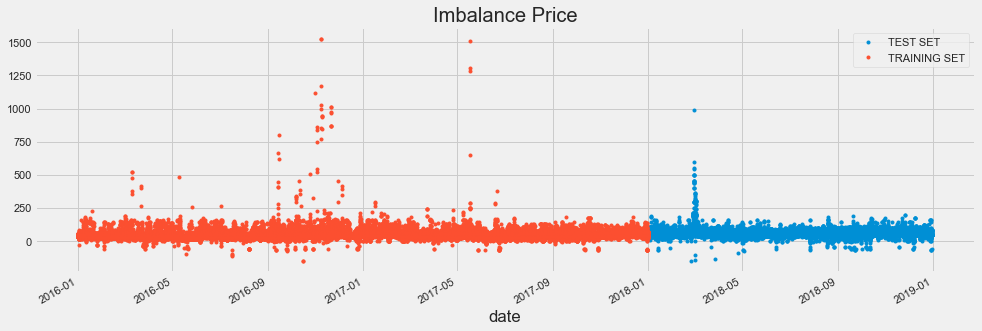

In [65]:
# Plot train and test so you can see where we have split
plt = ImbPrice_test .rename(columns={'imbalance_price': 'TEST SET'})\
            .join(ImbPrice_train.rename(columns={'imbalance_price': 'TRAINING SET'}),
                    how='outer') \
            .plot(figsize=(15,5), title='Imbalance Price', style='.')


### ---------- Implement Baseline/Univariate Model  - Prophet model -----------

- Prophet model expects the dataset to be named a specific way. 
- So, need to rename dataframe columns i.e (date as ds and target vairable as y) before imputing into the model.

In [66]:
# Format train data for prophet model using ds and y
#ImbPrice_train= ImbPrice_train.reset_index()
#ImbPrice_train = ImbPrice_train.rename(columns={'date':'ds','imbalance_price':'y'})
#ImbPrice_train.head()

In [67]:
# Setup and train model and fit
# taking 95% confidence interval # default is 80
BaselineModel = Prophet()
BaselineModel=Prophet(changepoint_prior_scale=0.01, interval_width = 0.95, daily_seasonality=True).fit(ImbPrice_train.reset_index() \
              .rename(columns={'date':'ds',
                               'imbalance_price':'y'}))

In [68]:
# Predict on training set with model
ImbalancePrice_Test_Forecast = BaselineModel.predict(df=ImbPrice_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

In [69]:
ImbalancePrice_Test_Forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,48.555277,-17.876609,135.185920,48.555277,48.555277,6.409835,6.409835,6.409835,1.140147,1.140147,1.140147,1.729911,1.729911,1.729911,3.539778,3.539778,3.539778,0.0,0.0,0.0,54.965113
1,2018-01-02,48.555277,-21.472229,134.186674,48.555277,48.555277,6.409835,6.409835,6.409835,1.140147,1.140147,1.140147,1.729911,1.729911,1.729911,3.539778,3.539778,3.539778,0.0,0.0,0.0,54.965113
2,2018-01-02,48.555277,-20.532350,124.100293,48.555277,48.555277,6.409835,6.409835,6.409835,1.140147,1.140147,1.140147,1.729911,1.729911,1.729911,3.539778,3.539778,3.539778,0.0,0.0,0.0,54.965113
3,2018-01-02,48.555277,-20.624008,130.903207,48.555277,48.555277,6.409835,6.409835,6.409835,1.140147,1.140147,1.140147,1.729911,1.729911,1.729911,3.539778,3.539778,3.539778,0.0,0.0,0.0,54.965113
4,2018-01-02,48.555277,-21.868459,133.366408,48.555277,48.555277,6.409835,6.409835,6.409835,1.140147,1.140147,1.140147,1.729911,1.729911,1.729911,3.539778,3.539778,3.539778,0.0,0.0,0.0,54.965113


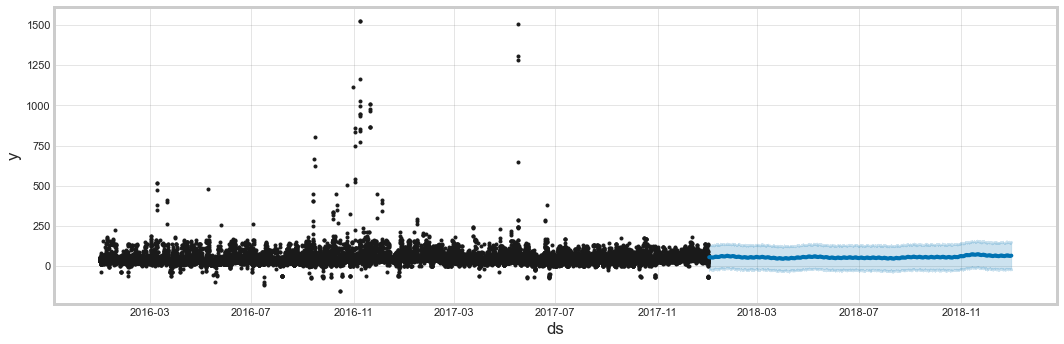

In [72]:
# Plot the forecast
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = BaselineModel.plot(ImbalancePrice_Test_Forecast,ax=ax)

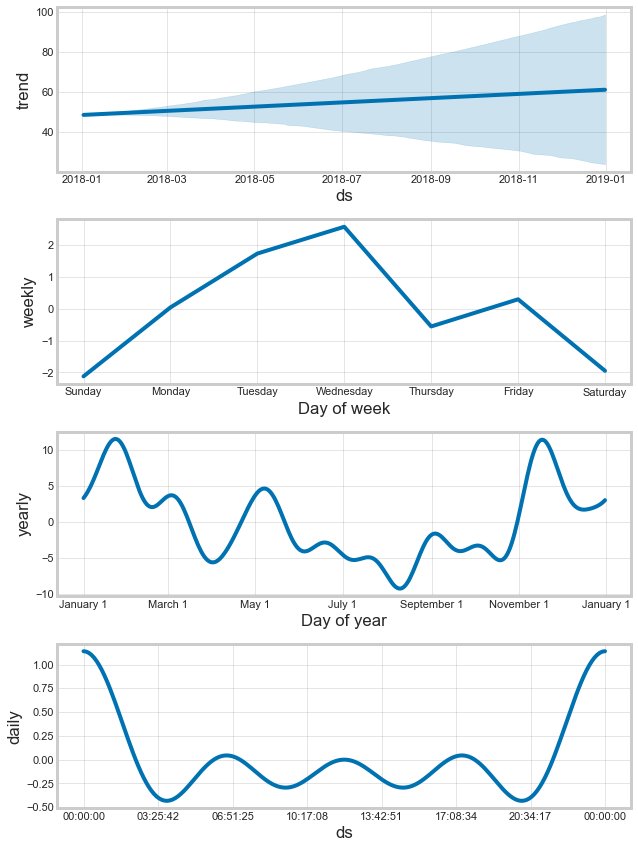

In [73]:
# Plot the components of the model
fig = BaselineModel.plot_components(ImbalancePrice_Test_Forecast)

### ------- Compare Forecast To Actual -----------

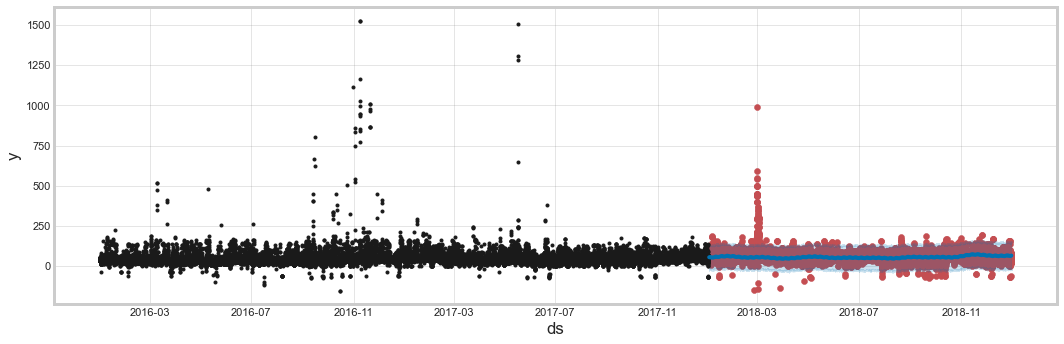

In [74]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ImbPrice_test.index, ImbPrice_test['imbalance_price'], color='r')
fig = BaselineModel.plot(ImbalancePrice_Test_Forecast, ax=ax)

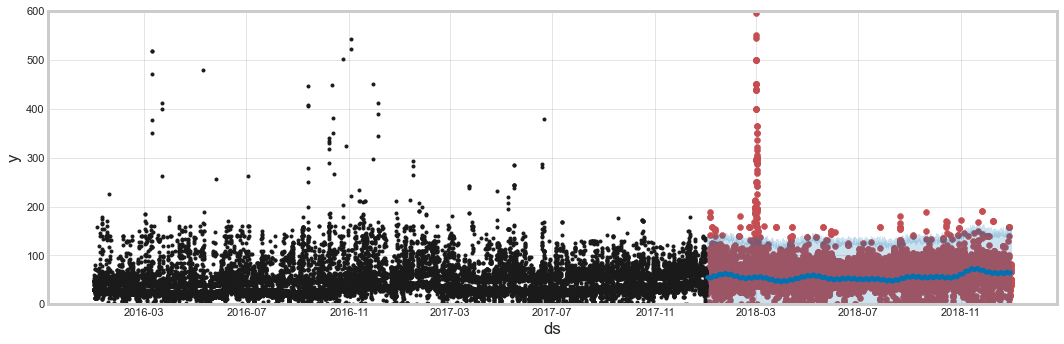

In [75]:
# Zooming the view and see actual points
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ImbPrice_test.index, ImbPrice_test['imbalance_price'], color='r')
ax.set_ylim(0, 600)
fig = BaselineModel.plot(ImbalancePrice_Test_Forecast, ax=ax)

In [76]:
### --------- Error Metrics -------------

In [77]:
mse = mean_squared_error(y_true=ImbPrice_test['imbalance_price'],
                   y_pred=ImbalancePrice_Test_Forecast['yhat'])
mae = mean_absolute_error(y_true=ImbPrice_test['imbalance_price'],
                   y_pred=ImbalancePrice_Test_Forecast['yhat'])
print("Mean Squared Error is : ",mse)
print("Mean Absolute Error is: ",mae)
print("Root Mean Squared Error is: ",sqrt(mse))

Mean Squared Error is :  937.0644708636061
Mean Absolute Error is:  19.126072632659056
Root Mean Squared Error is:  30.611508797568376


### Results Discussion:
#### MSE:
    - The mean squared error (MSE) of an estimator measures the average of the squares of the errors i.e., the AVG Squared difference between the estimated values and forecasted/estimated. 
    - The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

#### RMSE:
    - Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily imbalance price change in the test dataset forecasting within 19.50.
    - Overall this is a good model so far.

## --------- Future 15 Min Interval Forecasting -----------

In [78]:
# First tain model with complete data
print(ImplementationDataFrame.shape)
ImplementationDataFrame.head()

(52608, 1)


,imbalance_price
date,
2016-01-01,29.60000
2016-01-01,48.13640
2016-01-01,49.02361
2016-01-01,46.00000
2016-01-01,48.50000


In [79]:
# Setup and train model and fit
# taking 95% confidence interval # default is 80
FinalBaseLine = Prophet()
FinalBaselLine =Prophet(changepoint_prior_scale=0.01, interval_width = 0.95, daily_seasonality=True).\
fit(ImplementationDataFrame.reset_index() \
              .rename(columns={'date':'ds',
                               'imbalance_price':'y'}))



In [80]:
# Future 100 periods i.e. each hour divided into 4 period
future_date = FinalBaselLine.make_future_dataframe( periods=100, freq='15 min', include_history = False)
future_date.head()

,ds
0,2018-12-31 00:15:00
1,2018-12-31 00:30:00
2,2018-12-31 00:45:00
3,2018-12-31 01:00:00
4,2018-12-31 01:15:00


In [81]:
# Predict on training set with model
Future_Forecast = FinalBaselLine.predict(df=future_date)

In [83]:
fig = px.line(Future_Forecast, x="ds", y="yhat", 
            labels={
                     "ds": "Date & Time",
                     "yhat": "Price",
                 },
              title='Future Forecasting With 15 minute of Interval')
fig.show()

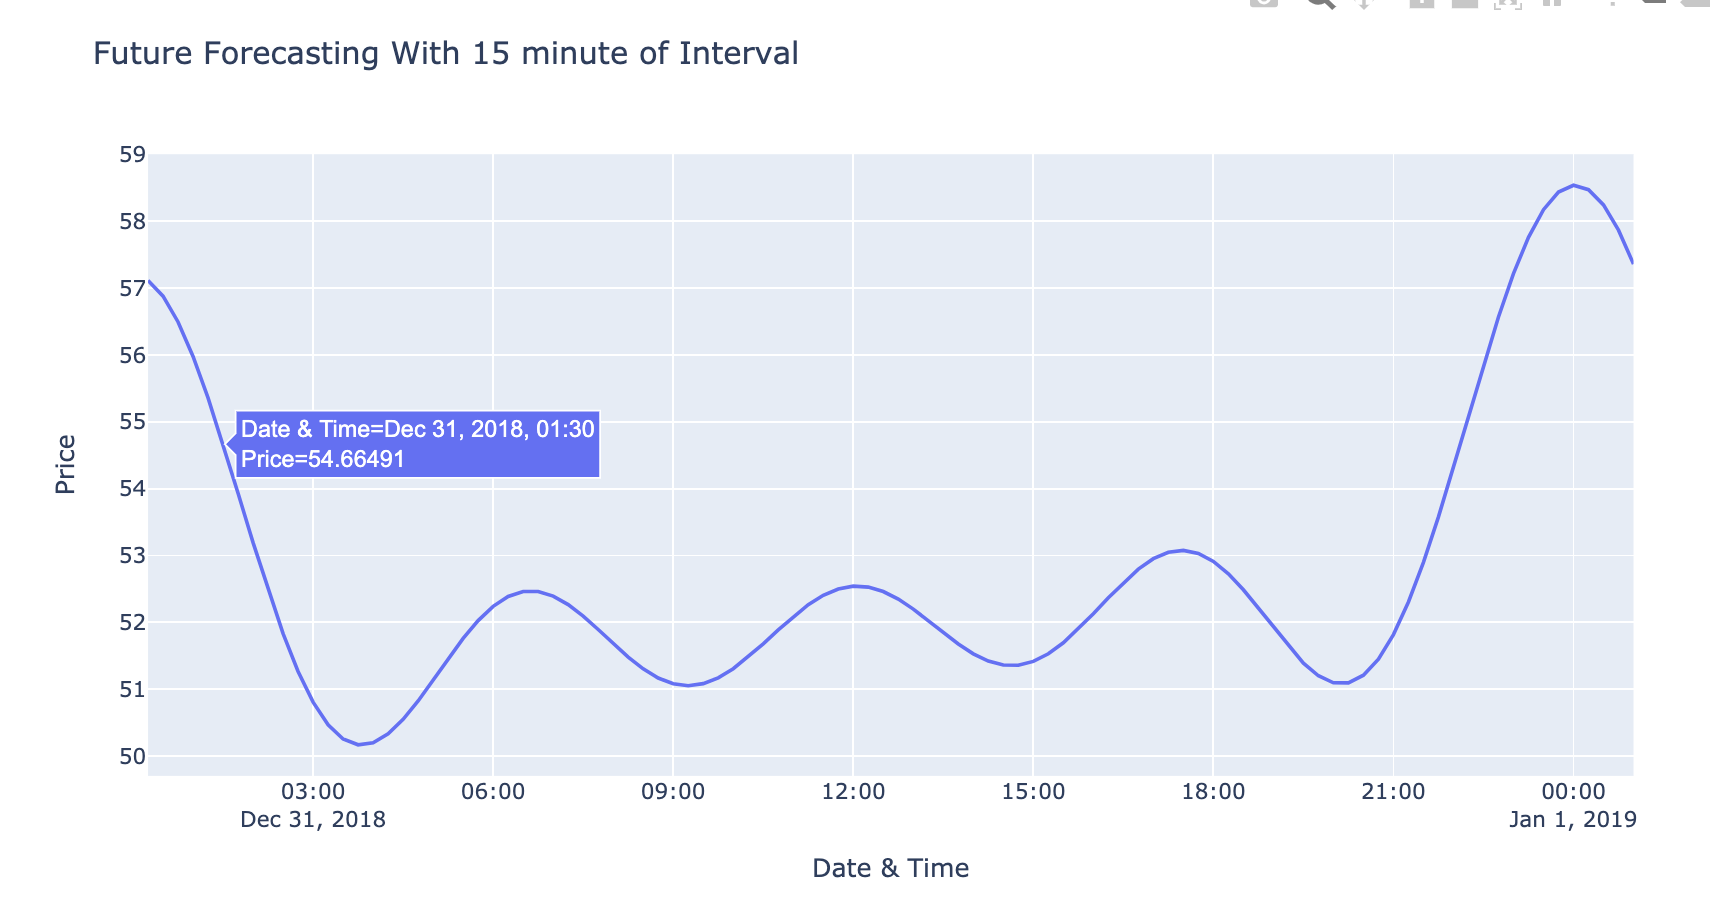

# ------------------------------ Multivariant Forecasting  ------------------------

In [84]:
# I am choosing 5 most highly correlated factors which influence imbalance_price
#MultiVariant = PartBData[['date','imbalance_price','net_imbalance_volume','market_price','ahead_auction_price','demand','hydropower']]
MultiVariant = PartBData[['date','imbalance_price','market_price','ahead_auction_price','demand','hydropower']]
MultiVariant.head()


,date,imbalance_price,market_price,ahead_auction_price,demand,hydropower
0,2016-01-01,29.60000,30.86,31.10,14163.0,0.0
1,2016-01-01,48.13640,32.71,31.10,14467.0,0.0
2,2016-01-01,49.02361,35.56,37.58,14485.5,0.0
3,2016-01-01,46.00000,36.08,37.58,14106.5,7.5
4,2016-01-01,48.50000,36.22,36.53,13615.5,0.0


In [85]:
# prepare data for prophet
MultiVariant = MultiVariant.rename(columns={'date':'ds','imbalance_price':'y'})
MultiVariant.head()

,ds,y,market_price,ahead_auction_price,demand,hydropower
0,2016-01-01,29.60000,30.86,31.10,14163.0,0.0
1,2016-01-01,48.13640,32.71,31.10,14467.0,0.0
2,2016-01-01,49.02361,35.56,37.58,14485.5,0.0
3,2016-01-01,46.00000,36.08,37.58,14106.5,7.5
4,2016-01-01,48.50000,36.22,36.53,13615.5,0.0


### ------ Split Data --------

In [86]:
split_date = '2017-12-31'
MultiImbPrice_train = MultiVariant.loc[MultiVariant.ds <= split_date].copy()
MultiImbPrice_test = MultiVariant.loc[MultiVariant.ds > split_date].copy()

In [87]:
MultiImbPrice_train.head()

,ds,y,market_price,ahead_auction_price,demand,hydropower
0,2016-01-01,29.60000,30.86,31.10,14163.0,0.0
1,2016-01-01,48.13640,32.71,31.10,14467.0,0.0
2,2016-01-01,49.02361,35.56,37.58,14485.5,0.0
3,2016-01-01,46.00000,36.08,37.58,14106.5,7.5
4,2016-01-01,48.50000,36.22,36.53,13615.5,0.0


In [88]:
MultiImbPrice_test.head()

,ds,y,market_price,ahead_auction_price,demand,hydropower
35088,2018-01-01,55.94000,47.27,47.14,13206.5,0.0
35089,2018-01-01,55.94000,48.57,47.14,13565.0,0.0
35090,2018-01-01,62.94000,52.32,54.60,13689.0,103.0
35091,2018-01-01,31.00000,51.18,54.60,13373.0,0.0
35092,2018-01-01,60.81165,46.08,46.63,13084.5,0.0


### ---------- Training Model -----------

In [89]:
# taking 95% confidence interval # default is 80
# as i am asumuming that maximum capacity of increase is 250

MultiVariantModel = Prophet(changepoint_prior_scale=0.01, interval_width = 0.95, daily_seasonality=True)

### For multivariate - Theory
- By default prophet take two variable, i.e independent and dependent.
- To add multivariate/extra features to model
    - We take help of add_regressor() function

In [90]:
# Some helper functions
def VisualizeTrend2(dataframe,colname, label):
    plt.gcf().set_size_inches(10, 10)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dataframe.ds, y=dataframe[colname], mode='lines', name='demand'))
    fig.update_layout(showlegend=True, title = label, xaxis_title="Date/Time", yaxis_title="Demand",)
    fig.show()
    return None

In [94]:
# To identify the mode type
label = "Analyse Trend of Factors"
#VisualizeTrend2(MultiVariant,'net_imbalance_volume', label)
#VisualizeTrend2(MultiVariant,'market_price', label)
#VisualizeTrend2(MultiVariant,'ahead_auction_price', label)
#VisualizeTrend2(MultiVariant,'demand', label)
#VisualizeTrend2(MultiVariant,'hydropower', label)

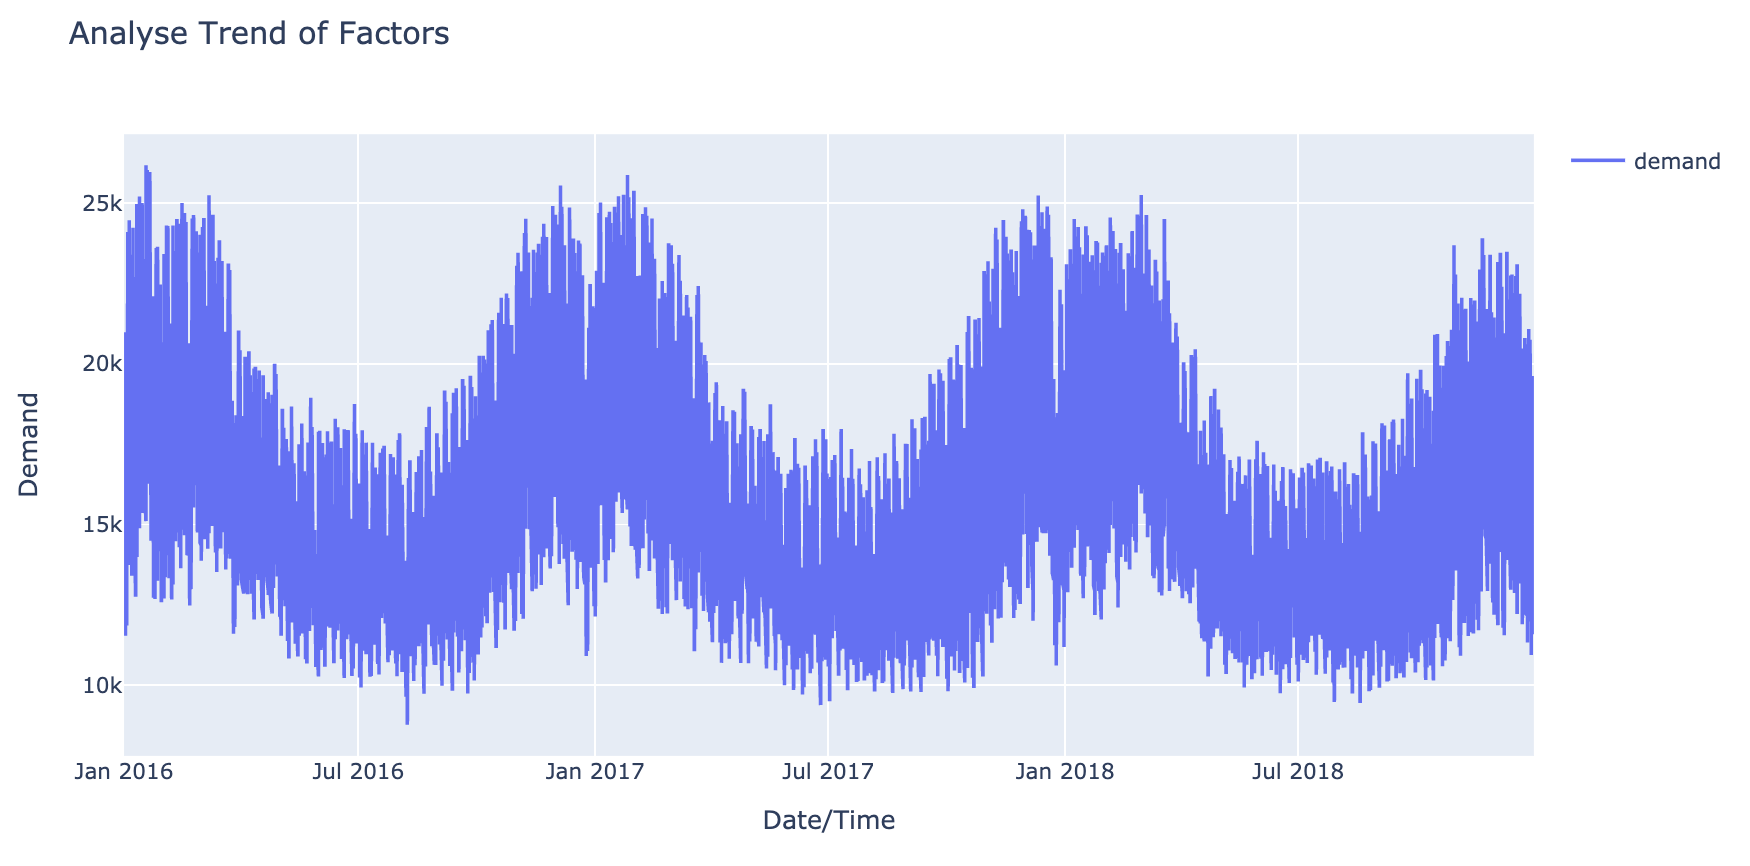

In [95]:
# Standardizing data because the data range is different for each feature 
# and because of that gradient descent graph will take huge curve.
# default mode is additive
# Taking additive as magintude is not changing exponentially.
MultiVariantModel.add_regressor('market_price',standardize = True,mode = 'additive')
MultiVariantModel.add_regressor('ahead_auction_price',standardize = True,mode = 'additive')
MultiVariantModel.add_regressor('demand',standardize = True,mode = 'additive')
MultiVariantModel.add_regressor('hydropower',standardize = True,mode = 'additive')



In [96]:
# Now fit the model with train data
MultiVariantModel.fit(MultiImbPrice_train)

In [97]:
# lets print parameter
MultiVariantModel.params

{'k': array([[-0.00168682]]),
 'm': array([[0.02097805]]),
 'delta': array([[ 1.50976745e-07, -4.42981583e-03, -2.95153827e-03,
         -1.00234712e-03,  1.35294167e-07,  1.06034638e-02,
         -3.65035233e-07,  1.60000829e-07,  6.18182571e-07,
          3.09915010e-03,  1.76801270e-02,  3.82964792e-08,
         -2.91068521e-03, -2.24801691e-02,  4.48205147e-07,
          1.78586722e-06,  4.35134408e-04,  2.11464324e-03,
          4.45855463e-04,  5.32312748e-04,  5.01818106e-07,
          7.69325920e-07,  6.28917144e-05,  4.96692035e-04,
         -1.26269713e-07]]),
 'sigma_obs': array([[0.0230266]]),
 'beta': array([[-7.01169956e-04,  3.04450269e-04, -9.35964638e-04,
          6.28602704e-04,  2.46013836e-04,  6.55679519e-04,
         -1.01582744e-04, -1.19098877e-03,  1.38392501e-04,
         -9.10611641e-04,  5.88810835e-04,  4.28018557e-04,
          5.64381613e-04,  8.73153425e-05,  1.28451619e-04,
          2.85067502e-04, -6.67871508e-04,  4.02880387e-04,
         -6.1475369

In [98]:
# Forecasting with all multivarient variables
# In real scenario this data has been gather from other sources
# If we dont have sources then we have to forcast this values using other models and use the same.
Forcasting_Results = MultiVariantModel.predict(MultiImbPrice_test)

In [99]:
Forcasting_Results.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,ahead_auction_price,ahead_auction_price_lower,ahead_auction_price_upper,daily,daily_lower,daily_upper,demand,demand_lower,demand_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,hydropower,hydropower_lower,hydropower_upper,market_price,market_price_lower,market_price_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,32.436107,-24.969797,111.199719,32.436084,32.436107,8.375853,8.375853,8.375853,-0.874475,-0.874475,-0.874475,9.88239,9.88239,9.88239,-1.412569,-1.412569,-1.412569,-1.447599,-1.447599,-1.447599,-3.973360,-3.973360,-3.973360,4.812806,4.812806,4.812806,-1.026163,-1.026163,-1.026163,0.967226,0.967226,0.967226,0.0,0.0,0.0,40.811960
1,2018-01-01,32.436107,-10.633839,130.458122,32.436084,32.436107,27.051757,27.051757,27.051757,-2.475602,-2.475602,-2.475602,9.88239,9.88239,9.88239,0.324552,0.324552,0.324552,17.228305,17.228305,17.228305,6.280929,6.280929,6.280929,13.098426,13.098426,13.098426,-1.026163,-1.026163,-1.026163,0.967226,0.967226,0.967226,0.0,0.0,0.0,59.487864
2,2018-01-01,32.436107,-13.616915,122.682602,32.436084,32.436107,25.472840,25.472840,25.472840,-2.475602,-2.475602,-2.475602,9.88239,9.88239,9.88239,0.307107,0.307107,0.307107,15.649387,15.649387,15.649387,3.252581,3.252581,3.252581,14.565301,14.565301,14.565301,-1.026163,-1.026163,-1.026163,0.967226,0.967226,0.967226,0.0,0.0,0.0,57.908947
3,2018-01-01,32.436107,-19.097765,115.193629,32.436084,32.436107,18.511272,18.511272,18.511272,-2.475602,-2.475602,-2.475602,9.88239,9.88239,9.88239,0.344208,0.344208,0.344208,8.687819,8.687819,8.687819,-0.465622,-0.465622,-0.465622,11.284836,11.284836,11.284836,-1.026163,-1.026163,-1.026163,0.967226,0.967226,0.967226,0.0,0.0,0.0,50.947379
4,2018-01-01,32.436107,-21.746131,120.269601,32.436084,32.436107,17.051857,17.051857,17.051857,-2.475602,-2.475602,-2.475602,9.88239,9.88239,9.88239,0.356984,0.356984,0.356984,7.228404,7.228404,7.228404,0.995936,0.995936,0.995936,8.351086,8.351086,8.351086,-1.026163,-1.026163,-1.026163,0.967226,0.967226,0.967226,0.0,0.0,0.0,49.487964


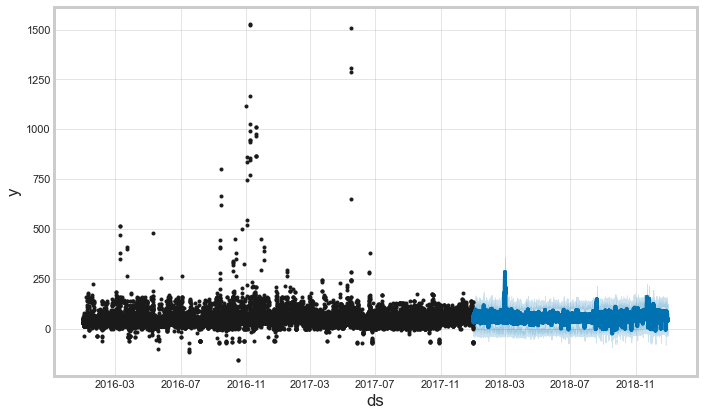

In [100]:
fig = MultiVariantModel.plot(Forcasting_Results) 

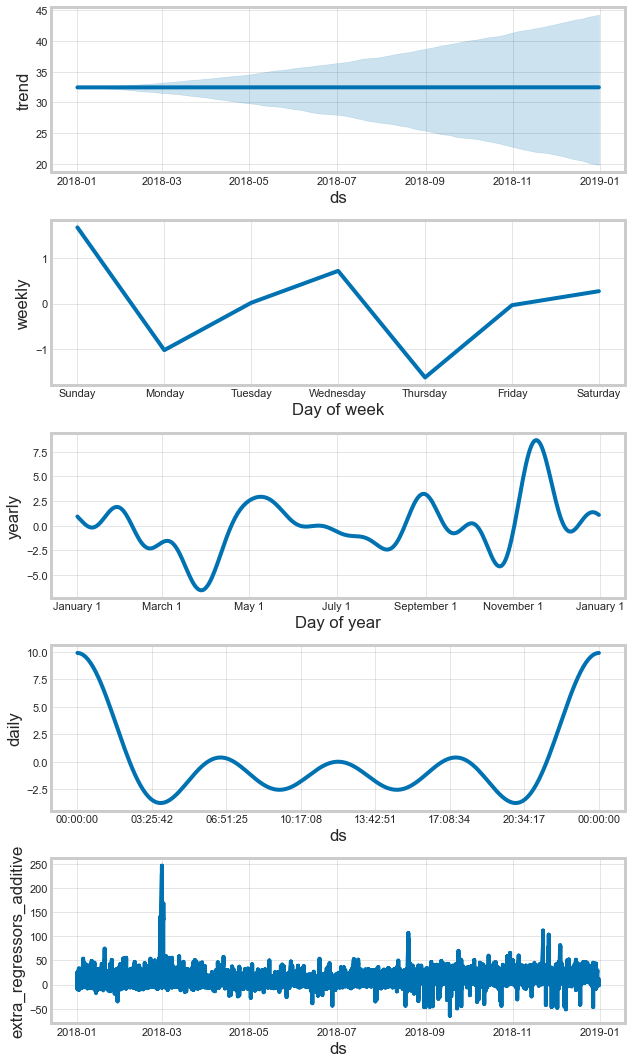

In [101]:
plot = MultiVariantModel.plot_components(Forcasting_Results) 

### ------ Plot with actual test data -----

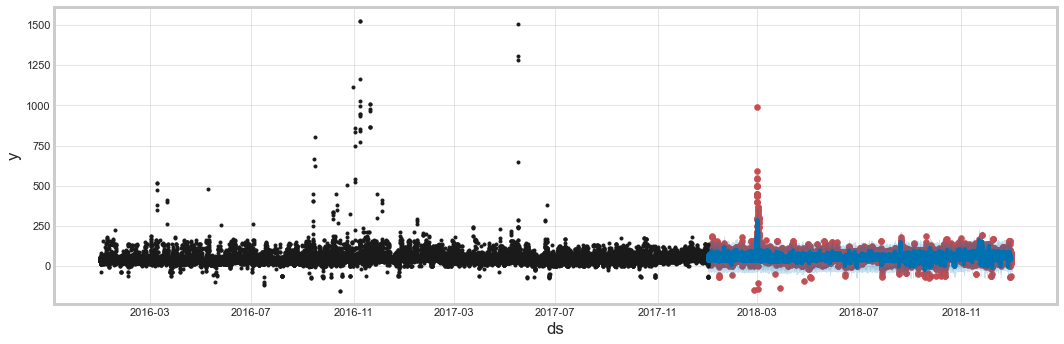

In [102]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(MultiImbPrice_test.ds, MultiImbPrice_test['y'], color='r')
fig = MultiVariantModel.plot(Forcasting_Results, ax=ax)

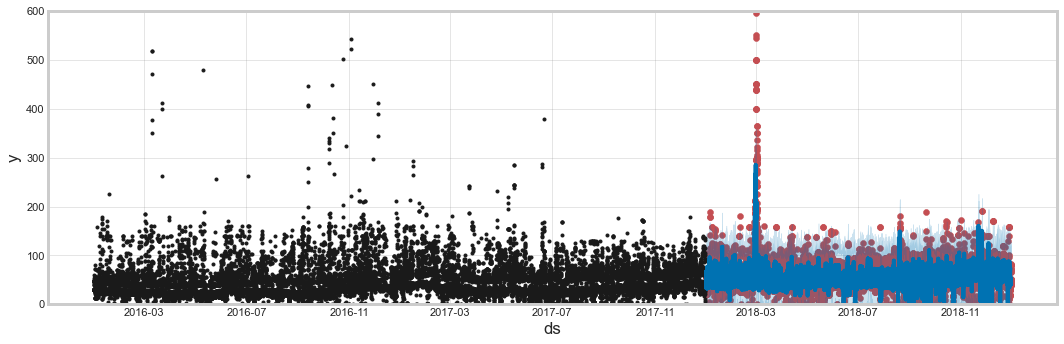

In [103]:
# Maximum the view and see actual points
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(MultiImbPrice_test.ds, MultiImbPrice_test['y'], color='r')
ax.set_ylim(0, 600)
fig = MultiVariantModel.plot(Forcasting_Results, ax=ax)


### -------------- Calculate Error Metrics ---------------

In [104]:
mse = mean_squared_error(y_true=MultiImbPrice_test['y'],
                   y_pred=Forcasting_Results['yhat'])
mae = mean_absolute_error(y_true=MultiImbPrice_test['y'],
                   y_pred=Forcasting_Results['yhat'])
print("Mean Squared Error is : ",mse)
print("Mean Absolute Error is: ",mae)
print("Root Mean Squared Error is: ",sqrt(mse))

Mean Squared Error is :  993.0327817487749
Mean Absolute Error is:  19.967062101864176
Root Mean Squared Error is:  31.512422657561174


### Results Discussion:
- As the RMSE of multivariate model is slightly more or approximately equal than baseline model.
- This happen because of outliers as we can see some affect has been observed on forecasting.
- But still model is performing comparitively good.

## -------- Future 15 min Interval Forecasting for single day ------------

In [106]:
# First tain model with complete multivariate data
print(MultiVariant.shape)
#MultiVariant.tail(50)

(52608, 6)


In [107]:
MultiVariant.head()

,ds,y,market_price,ahead_auction_price,demand,hydropower
0,2016-01-01,29.60000,30.86,31.10,14163.0,0.0
1,2016-01-01,48.13640,32.71,31.10,14467.0,0.0
2,2016-01-01,49.02361,35.56,37.58,14485.5,0.0
3,2016-01-01,46.00000,36.08,37.58,14106.5,7.5
4,2016-01-01,48.50000,36.22,36.53,13615.5,0.0


In [108]:
# Setup and train model and fit
# taking 95% confidence interval # default is 80
FinalMultivarModel = Prophet()
FinalMultivarModel = Prophet(changepoint_prior_scale=0.01, interval_width = 0.95, daily_seasonality=True)

In [109]:
# Train multivariate model
FinalMultivarModel.add_regressor('market_price',standardize = True,mode = 'additive')
FinalMultivarModel.add_regressor('ahead_auction_price',standardize = True,mode = 'additive')
FinalMultivarModel.add_regressor('demand',standardize = True,mode = 'additive')
FinalMultivarModel.add_regressor('hydropower',standardize = True,mode = 'additive')

In [110]:
# Setup and train model and fit
# taking 95% confidence interval # default is 80
FinalMultivarModel = FinalMultivarModel.fit(MultiVariant)


In [111]:
# Future 100 periods i.e. each hour divided into 4 period
future_date = FinalMultivarModel.make_future_dataframe( periods=100, freq='15 min', include_history = False)
future_date.tail()

,ds
95,2019-01-01 00:00:00
96,2019-01-01 00:15:00
97,2019-01-01 00:30:00
98,2019-01-01 00:45:00
99,2019-01-01 01:00:00


In [112]:
Future_DataFrame = MultiVariant[52560:]
Future_DataFrame.head()

,ds,y,market_price,ahead_auction_price,demand,hydropower
52560,2018-12-31,46.10,54.57,57.00,12433.5,0.0
52561,2018-12-31,46.15,56.60,57.00,12521.5,0.0
52562,2018-12-31,47.10,55.37,55.92,12529.0,0.0
52563,2018-12-31,41.60,53.25,55.92,12245.5,0.0
52564,2018-12-31,41.60,52.73,51.06,12155.5,0.0


In [113]:
# Multivariate values for next day has been imputed by using mean of last day value
future_date['market_price'] = Future_DataFrame.market_price.mean()
future_date['ahead_auction_price'] = Future_DataFrame.ahead_auction_price.mean()
future_date['demand'] = Future_DataFrame.demand.mean()
future_date['hydropower'] = Future_DataFrame.hydropower.mean()
future_date.head()

,ds,market_price,ahead_auction_price,demand,hydropower
0,2018-12-31 00:15:00,53.849583,57.143333,15194.541667,66.375
1,2018-12-31 00:30:00,53.849583,57.143333,15194.541667,66.375
2,2018-12-31 00:45:00,53.849583,57.143333,15194.541667,66.375
3,2018-12-31 01:00:00,53.849583,57.143333,15194.541667,66.375
4,2018-12-31 01:15:00,53.849583,57.143333,15194.541667,66.375


In [114]:
# Predict on training set with model
Future_Multivar_Forecast = FinalMultivarModel.predict(df=future_date)

In [116]:
fig = px.line(Future_Multivar_Forecast, x="ds", y="yhat", 
              labels={
                     "ds": "Date & Time",
                    "yhat": "Price",
                },
             title='Future Multivariate Forecasting  With 15 minute of Interval')
fig.show()

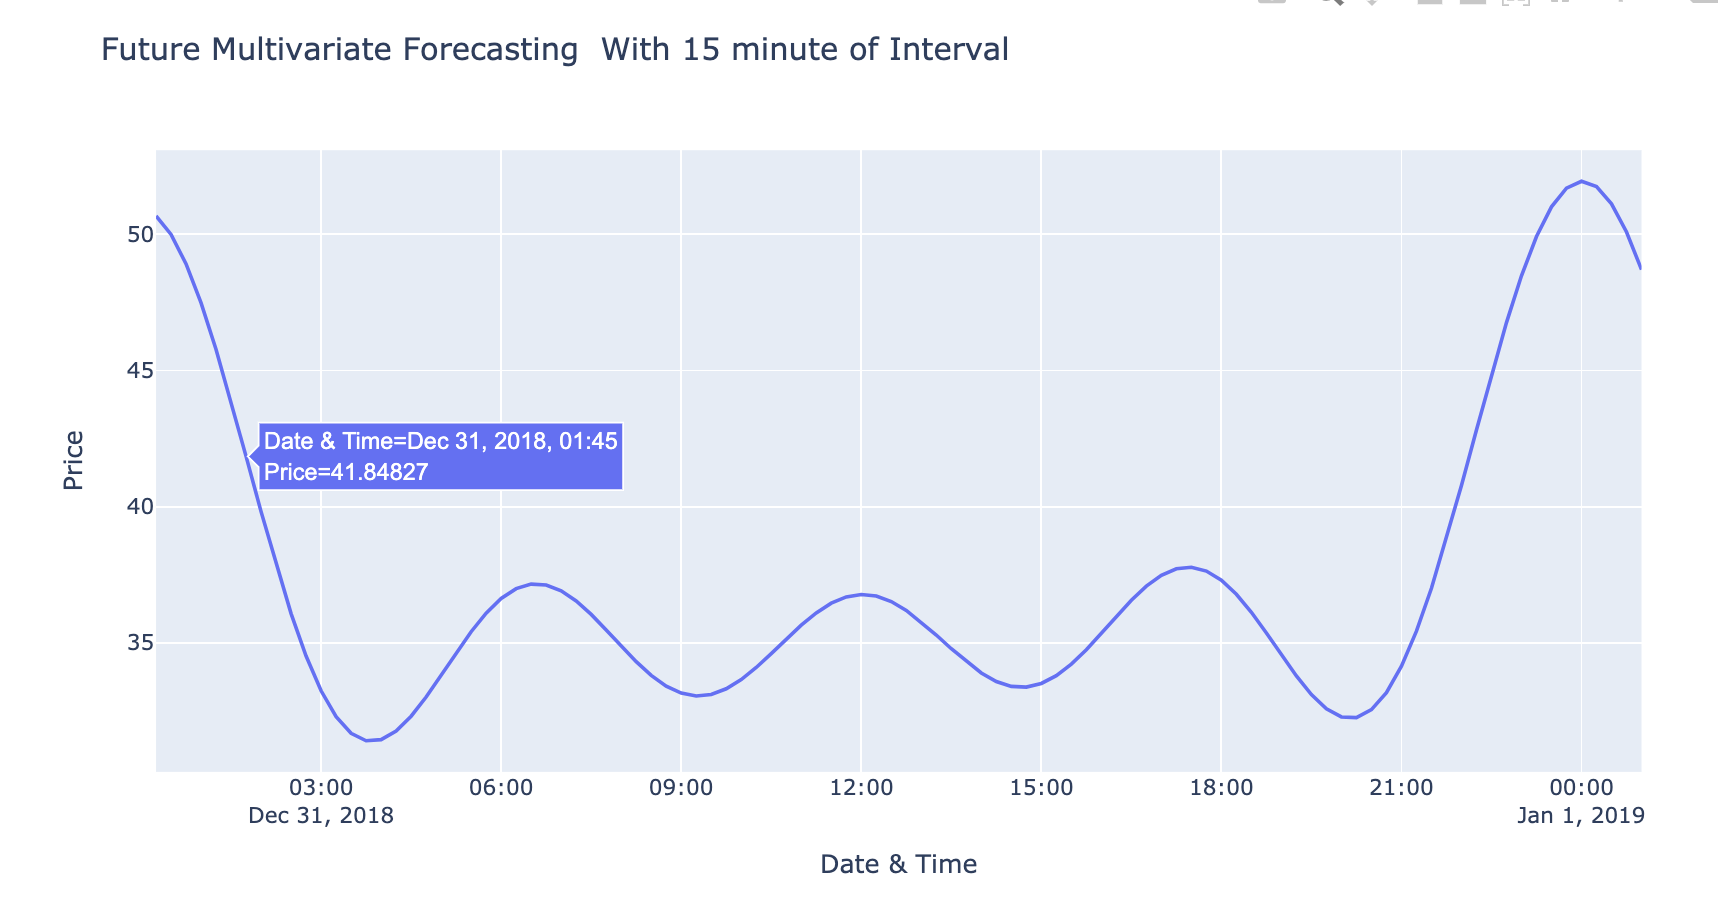

# ----------------- CONCLUSION --------------------------
## Part A:
- After performing Pearson and Spearman correlation we found below Top 5 Main factor influencing the imbalance_price.
- Main Factors 
    1. net_imbalance_volume
    2. Market_Price
    3. Ahead_Auction_Price
    4. Demand
    5. Hydropower
- Also after applying this factors with Facebook Prophet forecasting model they shown their good impact of correlation.

## Part B:
- As data have much outliers I choose Facebook Prophet forecasting model.
- Model perform well in both condition Univariete and Multivariet.
- The Final Forecasting Results which successfully forecast next 15 min imbalance_price:
- Univariate:
Univariate.png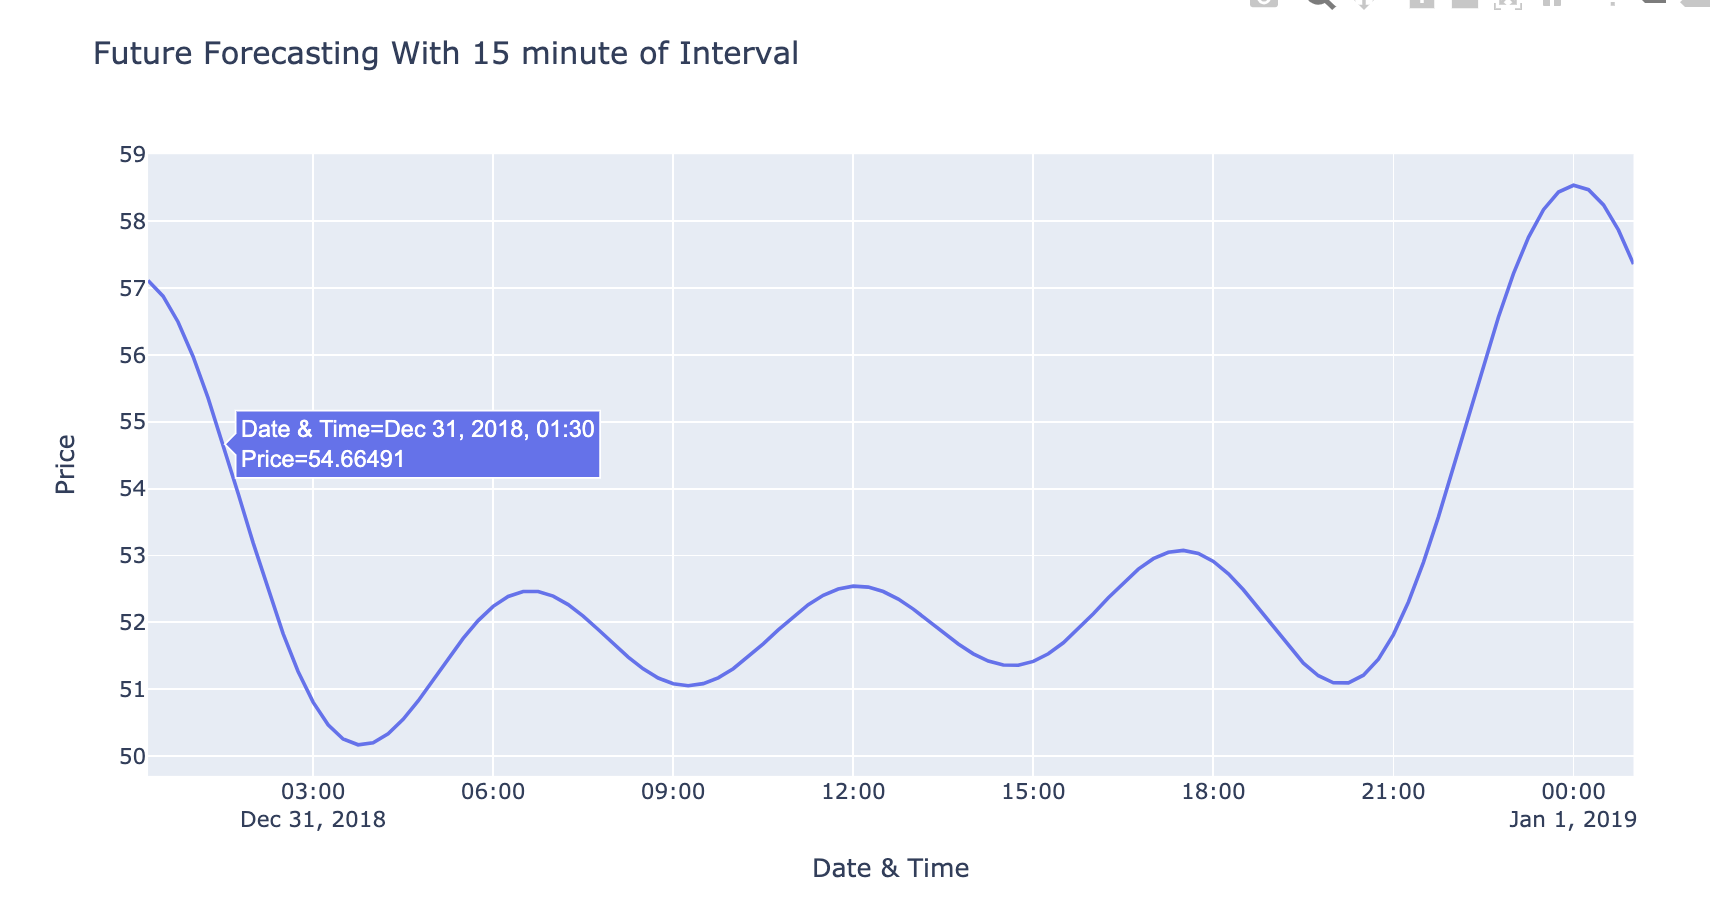

- Multivariate:
Multivariate.png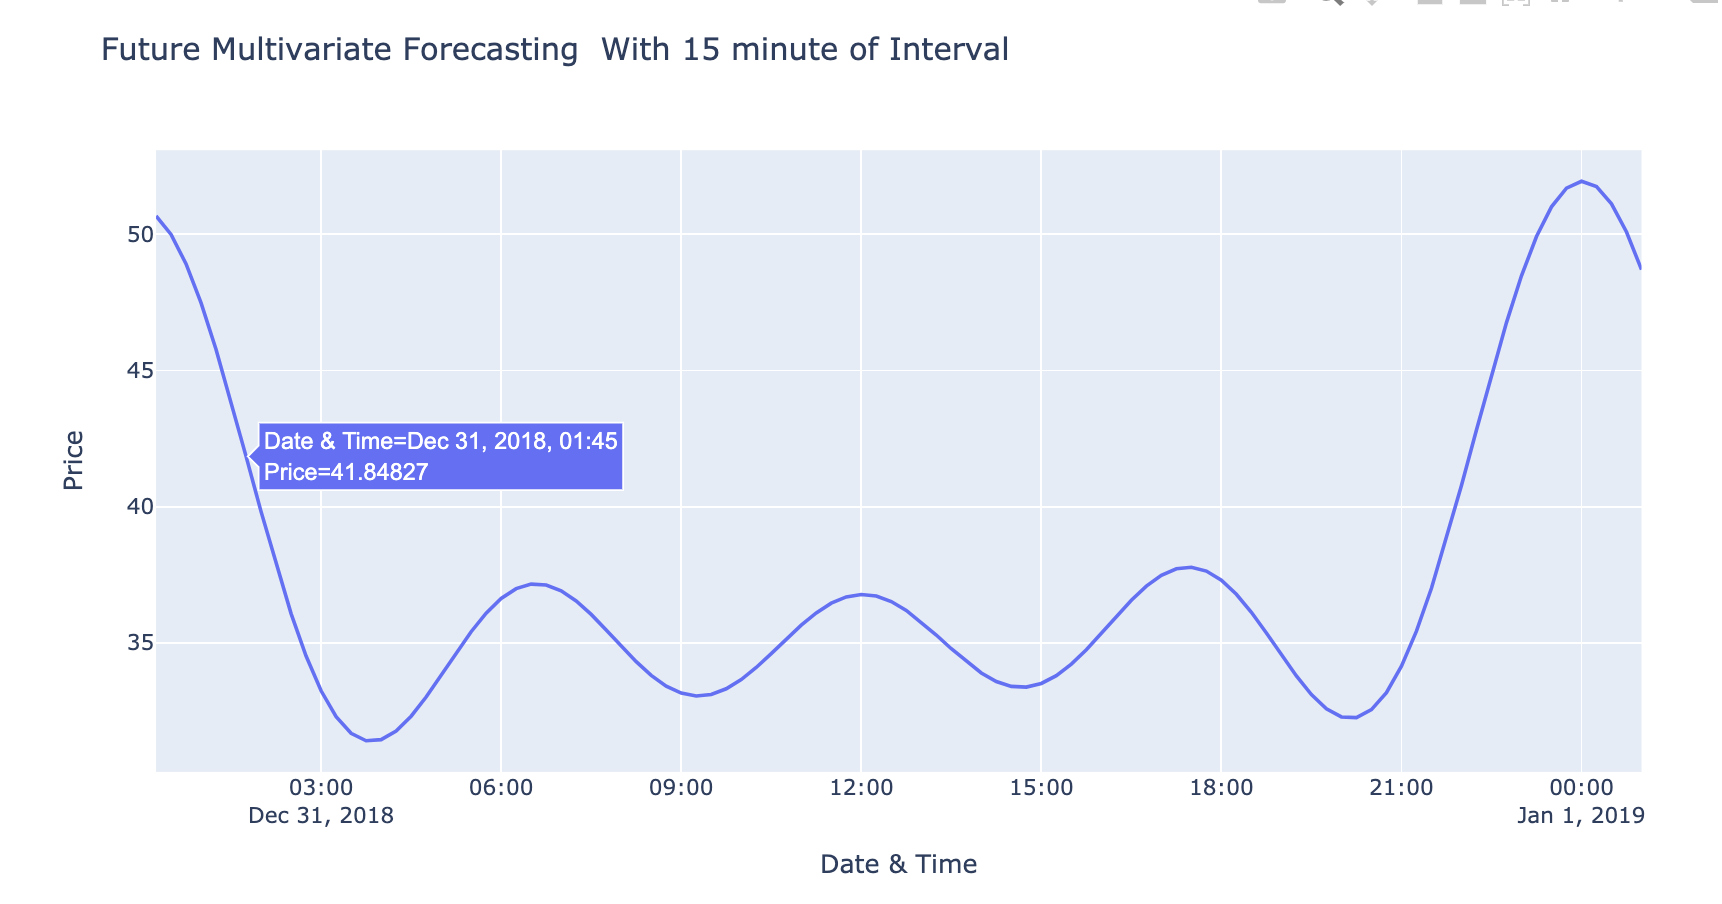